## **Capstone Project - Car Detection**

#### Importing libraries

In [4]:
import pandas as pd
import numpy as np
from math import sqrt
import os
import h5py

import pickle
import logging
import random

from zipfile import ZipFile
import cv2
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline 

logging.getLogger().setLevel(logging.CRITICAL)

from nltk import word_tokenize
import nltk
import re

# from sklearn.preprocessing import Normalizer, LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report, f1_score, make_scorer
# from sklearn.svm import SVC


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Concatenate, Reshape, UpSampling2D, Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, Dropout, ZeroPadding2D ,BatchNormalization
from tensorflow.keras.models import Model, Sequential

# from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

from tensorflow.keras.optimizers import Adam, SGD
# # from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# import cvlib as cv
# from PIL import Image




### <font color='blue'>**1. Import the dataset**</font>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
file = os.chdir('/content/drive/MyDrive/Colab Notebooks/Capstone')  #change dir

In [9]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Capstone


####Import data in dataframes

In [6]:
#Different car labels
car_names = pd.read_csv( 'Car names and make.csv', header=None, names = ['CarLabel'] )

#Train data
train_data = pd.read_csv( 'Annotations/Train Annotations.csv', skiprows=1, names = ['ImageName', 'X1', 'Y1', 'X2' , 'Y2', 'Class'] )

#Test data
test_data = pd.read_csv( 'Annotations/Test Annotation.csv' , skiprows=1, names = ['ImageName', 'X1', 'Y1', 'X2' , 'Y2', 'Class'])

#Display few sample records
print (car_names.head() )
print ( )
print (train_data.head() )
print ( )
print (test_data.head() )

                     CarLabel
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012
3        Acura TL Type-S 2008
4        Acura TSX Sedan 2012

   ImageName   X1   Y1    X2    Y2  Class
0  00001.jpg   39  116   569   375     14
1  00002.jpg   36  116   868   587      3
2  00003.jpg   85  109   601   381     91
3  00004.jpg  621  393  1484  1096    134
4  00005.jpg   14   36   133    99    106

   ImageName   X1   Y1   X2   Y2  Class
0  00001.jpg   30   52  246  147    181
1  00002.jpg  100   19  576  203    103
2  00003.jpg   51  105  968  659    145
3  00004.jpg   67   84  581  407    187
4  00005.jpg  140  151  593  339    185


<b> Find class name with '/' 

In [7]:
for i in range(len(car_names)) :
  if '/' in car_names.loc[i,"CarLabel"]:
    print(car_names.loc[i,"CarLabel"])
    print(i)

Ram C/V Cargo Van Minivan 2012
173


Thus, there is only 1 class with '/' in it's name. 

In [8]:
#Replace '/' with '-' in the name
car_names.loc[173,'CarLabel'] = 'Ram C-V Cargo Van Minivan 2012'

Also, check and manually rename the folder. As checked, folder already has '-' in the name

### <font color='blue'>**2. Map training images to its classes and annotations.**</font>

In [9]:
car_names['Class'] = car_names.index + 1
car_train_df = pd.merge(train_data, car_names, how = 'left', left_on='Class', right_on='Class' )
car_train_df.head() 

,ImageName,X1,Y1,X2,Y2,Class,CarLabel
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012


### <font color='blue'>**3. Map Test images to its classes and annotations.**</font>

In [10]:
car_test_df = pd.merge(test_data, car_names, how = 'left', left_on='Class', right_on='Class' )
car_test_df.head() 

,ImageName,X1,Y1,X2,Y2,Class,CarLabel
0,00001.jpg,30,52,246,147,181,Suzuki Aerio Sedan 2007
1,00002.jpg,100,19,576,203,103,Ferrari 458 Italia Convertible 2012
2,00003.jpg,51,105,968,659,145,Jeep Patriot SUV 2012
3,00004.jpg,67,84,581,407,187,Toyota Camry Sedan 2012
4,00005.jpg,140,151,593,339,185,Tesla Model S Sedan 2012


### <font color='blue'>**EDA on CarLabel.**</font>

In [11]:
import nltk
nltk.download('punkt')

car_body_type = ["suv","sedan","type-s","type-r","convertible","coupe","wagon","hatchback","cab","supercab","van","minivan"]
car_body_type = [item.lower() for item in car_body_type]

car_make = ['am', 'general', 'acura', 'aston', 'martin', 'audi', 'bmw', 'bentley', 'bugatti', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 
            'dodge', 'eagle', 'fiat', 'ferrari', 'fisker', 'ford', 'gmc', 'geo', 'honda', 'hyundai', 'infiniti', 'isuzu',
            'jaguar', 'jeep', 'lamborghini', 'land', 'rover', 'lincoln', 'mini', 'cooper', 'maybach', 'mazda', 'mclaren', 'mercedes-benz', 
            'mitsubishi', 'nissan', 'plymouth', 'porsche', 'ram', 'rolls-royce', 'scion', 'spyker', 'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo', 'smart']
car_make = [item.lower() for item in car_make]

eda_df = car_test_df.copy()
eda_df["year"] = None
eda_df["make"] = None
eda_df["model"] = None
eda_df["body"] = None

pattern="[0-9][0-9][0-9][0-9]"
for col in eda_df.columns:
    if col == 'CarLabel':
        for index, row in eda_df.iterrows():
            #print(row[0])
            #car_body_type = [item.lower() for item in car_body_type]
            wordsl = word_tokenize(row[col].lower())
            print(index, wordsl)
            
            if len(wordsl)>1:
                year = re.findall(pattern,wordsl[len(wordsl)-1])#row[0]) 
                if year:
                    eda_df.loc[index, 'year'] = year[0]
                #print("Intersection between l1 and l2 @", index, list(set(wordsl).intersection(car_body_type)))
                body = list(set(wordsl).intersection(car_body_type))
                if body:
                    eda_df.loc[index, 'body'] = body[0]
                make = list(set(wordsl).intersection(car_make))
                #print(make)
                if make:
                    eda_df.loc[index, 'make'] = ' '.join(make)
                iden=year + body + make
                print(iden)
                model = list(set(wordsl).difference(iden))
                print(model)
                if model:
                    eda_df.loc[index, 'model'] = ' '.join(model)
 
eda_df.head( 10 )            

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\f_jim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0 ['suzuki', 'aerio', 'sedan', '2007']
['2007', 'sedan', 'suzuki']
['aerio']
1 ['ferrari', '458', 'italia', 'convertible', '2012']
['2012', 'convertible', 'ferrari']
['458', 'italia']
2 ['jeep', 'patriot', 'suv', '2012']
['2012', 'suv', 'jeep']
['patriot']
3 ['toyota', 'camry', 'sedan', '2012']
['2012', 'sedan', 'toyota']
['camry']
4 ['tesla', 'model', 's', 'sedan', '2012']
['2012', 'sedan', 'tesla']
['model', 's']
5 ['chrysler', 'town', 'and', 'country', 'minivan', '2012']
['2012', 'minivan', 'chrysler']
['and', 'country', 'town']
6 ['gmc', 'terrain', 'suv', '2012']
['2012', 'suv', 'gmc']
['terrain']
7 ['mercedes-benz', 's-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['s-class']
8 ['bmw', 'x5', 'suv', '2007']
['2007', 'suv', 'bmw']
['x5']
9 ['chevrolet', 'hhr', 'ss', '2010']
['2010', 'chevrolet']
['ss', 'hhr']
10 ['buick', 'verano', 'sedan', '2012']
['2012', 'sedan', 'buick']
['verano']
11 ['ford', 'freestar', 'minivan', '2007']
['2007', 'minivan', 'ford']
['freestar']


['2012', 'lamborghini']
['lp', 'gallardo', 'superleggera', '570-4']
99 ['dodge', 'magnum', 'wagon', '2008']
['2008', 'wagon', 'dodge']
['magnum']
100 ['toyota', '4runner', 'suv', '2012']
['2012', 'suv', 'toyota']
['4runner']
101 ['audi', 's5', 'convertible', '2012']
['2012', 'convertible', 'audi']
['s5']
102 ['bmw', 'm3', 'coupe', '2012']
['2012', 'coupe', 'bmw']
['m3']
103 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
104 ['honda', 'accord', 'sedan', '2012']
['2012', 'sedan', 'honda']
['accord']
105 ['isuzu', 'ascender', 'suv', '2008']
['2008', 'suv', 'isuzu']
['ascender']
106 ['bmw', 'm6', 'convertible', '2010']
['2010', 'convertible', 'bmw']
['m6']
107 ['hyundai', 'veloster', 'hatchback', '2012']
['2012', 'hatchback', 'hyundai']
['veloster']
108 ['bmw', '3', 'series', 'wagon', '2012']
['2012', 'wagon', 'bmw']
['3', 'series']
109 ['audi', 's6', 'sedan', '2011']
['2011', 'sedan', 'audi']
['s6']
110 ['scion', 'xd', 

200 ['audi', 'tts', 'coupe', '2012']
['2012', 'coupe', 'audi']
['tts']
201 ['honda', 'odyssey', 'minivan', '2012']
['2012', 'minivan', 'honda']
['odyssey']
202 ['rolls-royce', 'phantom', 'drophead', 'coupe', 'convertible', '2012']
['2012', 'coupe', 'convertible', 'rolls-royce']
['drophead', 'phantom']
203 ['mazda', 'tribute', 'suv', '2011']
['2011', 'suv', 'mazda']
['tribute']
204 ['bmw', '1', 'series', 'coupe', '2012']
['2012', 'coupe', 'bmw']
['series', '1']
205 ['honda', 'odyssey', 'minivan', '2012']
['2012', 'minivan', 'honda']
['odyssey']
206 ['chevrolet', 'avalanche', 'crew', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['crew', 'avalanche']
207 ['suzuki', 'kizashi', 'sedan', '2012']
['2012', 'sedan', 'suzuki']
['kizashi']
208 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
209 ['audi', 's4', 'sedan', '2007']
['2007', 'sedan', 'audi']
['s4']
210 ['bentley', 'continental', 'gt', 'coupe', '2007']
['2007', 'coupe', 

302 ['gmc', 'canyon', 'extended', 'cab', '2012']
['2012', 'cab', 'gmc']
['extended', 'canyon']
303 ['jeep', 'wrangler', 'suv', '2012']
['2012', 'suv', 'jeep']
['wrangler']
304 ['chevrolet', 'malibu', 'hybrid', 'sedan', '2010']
['2010', 'sedan', 'chevrolet']
['hybrid', 'malibu']
305 ['chevrolet', 'silverado', '1500', 'extended', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', 'extended', '1500']
306 ['honda', 'odyssey', 'minivan', '2012']
['2012', 'minivan', 'honda']
['odyssey']
307 ['ferrari', '458', 'italia', 'convertible', '2012']
['2012', 'convertible', 'ferrari']
['458', 'italia']
308 ['audi', 'r8', 'coupe', '2012']
['2012', 'coupe', 'audi']
['r8']
309 ['ford', 'f-450', 'super', 'duty', 'crew', 'cab', '2012']
['2012', 'cab', 'ford']
['crew', 'f-450', 'duty', 'super']
310 ['bentley', 'mulsanne', 'sedan', '2011']
['2011', 'sedan', 'bentley']
['mulsanne']
311 ['dodge', 'charger', 'srt-8', '2009']
['2009', 'dodge']
['charger', 'srt-8']
312 ['ferrari', '458', 'italia', 'coupe'

['2010', 'cab', 'dodge', 'ram']
['3500', 'crew', 'pickup']
407 ['nissan', 'leaf', 'hatchback', '2012']
['2012', 'hatchback', 'nissan']
['leaf']
408 ['porsche', 'panamera', 'sedan', '2012']
['2012', 'sedan', 'porsche']
['panamera']
409 ['cadillac', 'srx', 'suv', '2012']
['2012', 'suv', 'cadillac']
['srx']
410 ['spyker', 'c8', 'coupe', '2009']
['2009', 'coupe', 'spyker']
['c8']
411 ['audi', 's6', 'sedan', '2011']
['2011', 'sedan', 'audi']
['s6']
412 ['chevrolet', 'silverado', '1500', 'extended', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', 'extended', '1500']
413 ['hummer', 'h3t', 'crew', 'cab', '2010']
['2010', 'cab']
['crew', 'hummer', 'h3t']
414 ['hyundai', 'elantra', 'touring', 'hatchback', '2012']
['2012', 'hatchback', 'hyundai']
['touring', 'elantra']
415 ['dodge', 'durango', 'suv', '2012']
['2012', 'suv', 'dodge']
['durango']
416 ['eagle', 'talon', 'hatchback', '1998']
['1998', 'hatchback', 'eagle']
['talon']
417 ['gmc', 'canyon', 'extended', 'cab', '2012']
['2012', '

['2007', 'sedan', 'bentley']
['spur', 'continental', 'flying']
508 ['suzuki', 'sx4', 'sedan', '2012']
['2012', 'sedan', 'suzuki']
['sx4']
509 ['bmw', 'm3', 'coupe', '2012']
['2012', 'coupe', 'bmw']
['m3']
510 ['ford', 'f-450', 'super', 'duty', 'crew', 'cab', '2012']
['2012', 'cab', 'ford']
['crew', 'f-450', 'duty', 'super']
511 ['bmw', 'x6', 'suv', '2012']
['2012', 'suv', 'bmw']
['x6']
512 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
513 ['audi', '100', 'wagon', '1994']
['1994', 'wagon', 'audi']
['100']
514 ['ford', 'mustang', 'convertible', '2007']
['2007', 'convertible', 'ford']
['mustang']
515 ['bmw', '3', 'series', 'sedan', '2012']
['2012', 'sedan', 'bmw']
['3', 'series']
516 ['hummer', 'h2', 'sut', 'crew', 'cab', '2009']
['2009', 'cab']
['crew', 'hummer', 'sut', 'h2']
517 ['bmw', 'm6', 'convertible', '2010']
['2010', 'convertible', 'bmw']
['m6']
518 ['bmw', 'm5', 'sedan', '2010']
['2010', 'sedan', 'bmw']
['m5'

612 ['fiat', '500', 'convertible', '2012']
['2012', 'convertible', 'fiat']
['500']
613 ['hyundai', 'azera', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['azera']
614 ['dodge', 'charger', 'sedan', '2012']
['2012', 'sedan', 'dodge']
['charger']
615 ['chevrolet', 'malibu', 'sedan', '2007']
['2007', 'sedan', 'chevrolet']
['malibu']
616 ['cadillac', 'cts-v', 'sedan', '2012']
['2012', 'sedan', 'cadillac']
['cts-v']
617 ['ford', 'mustang', 'convertible', '2007']
['2007', 'convertible', 'ford']
['mustang']
618 ['scion', 'xd', 'hatchback', '2012']
['2012', 'hatchback', 'scion']
['xd']
619 ['gmc', 'yukon', 'hybrid', 'suv', '2012']
['2012', 'suv', 'gmc']
['hybrid', 'yukon']
620 ['dodge', 'charger', 'sedan', '2012']
['2012', 'sedan', 'dodge']
['charger']
621 ['smart', 'fortwo', 'convertible', '2012']
['2012', 'convertible', 'smart']
['fortwo']
622 ['dodge', 'caliber', 'wagon', '2007']
['2007', 'wagon', 'dodge']
['caliber']
623 ['hyundai', 'tucson', 'suv', '2012']
['2012', 'suv', 'hyundai']
['tuc

['1997', 'minivan', 'dodge']
['caravan']
715 ['dodge', 'durango', 'suv', '2007']
['2007', 'suv', 'dodge']
['durango']
716 ['bmw', 'm6', 'convertible', '2010']
['2010', 'convertible', 'bmw']
['m6']
717 ['smart', 'fortwo', 'convertible', '2012']
['2012', 'convertible', 'smart']
['fortwo']
718 ['ford', 'ranger', 'supercab', '2011']
['2011', 'supercab', 'ford']
['ranger']
719 ['honda', 'accord', 'coupe', '2012']
['2012', 'coupe', 'honda']
['accord']
720 ['bentley', 'continental', 'flying', 'spur', 'sedan', '2007']
['2007', 'sedan', 'bentley']
['spur', 'continental', 'flying']
721 ['bmw', '3', 'series', 'sedan', '2012']
['2012', 'sedan', 'bmw']
['3', 'series']
722 ['bmw', '3', 'series', 'wagon', '2012']
['2012', 'wagon', 'bmw']
['3', 'series']
723 ['land', 'rover', 'range', 'rover', 'suv', '2012']
['2012', 'suv', 'rover', 'land']
['range']
724 ['mini', 'cooper', 'roadster', 'convertible', '2012']
['2012', 'convertible', 'cooper', 'mini']
['roadster']
725 ['bugatti', 'veyron', '16.4', 'coupe

['1998', 'coupe', 'nissan']
['240sx']
814 ['geo', 'metro', 'convertible', '1993']
['1993', 'convertible', 'geo']
['metro']
815 ['lamborghini', 'reventon', 'coupe', '2008']
['2008', 'coupe', 'lamborghini']
['reventon']
816 ['ford', 'ranger', 'supercab', '2011']
['2011', 'supercab', 'ford']
['ranger']
817 ['bmw', 'm5', 'sedan', '2010']
['2010', 'sedan', 'bmw']
['m5']
818 ['ford', 'fiesta', 'sedan', '2012']
['2012', 'sedan', 'ford']
['fiesta']
819 ['mercedes-benz', 'sprinter', 'van', '2012']
['2012', 'van', 'mercedes-benz']
['sprinter']
820 ['hyundai', 'sonata', 'hybrid', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['hybrid', 'sonata']
821 ['chevrolet', 'corvette', 'convertible', '2012']
['2012', 'convertible', 'chevrolet']
['corvette']
822 ['ford', 'focus', 'sedan', '2007']
['2007', 'sedan', 'ford']
['focus']
823 ['chevrolet', 'corvette', 'convertible', '2012']
['2012', 'convertible', 'chevrolet']
['corvette']
824 ['gmc', 'acadia', 'suv', '2012']
['2012', 'suv', 'gmc']
['acadia']
825 [

['2007', 'suv', 'dodge']
['durango']
914 ['cadillac', 'cts-v', 'sedan', '2012']
['2012', 'sedan', 'cadillac']
['cts-v']
915 ['gmc', 'savana', 'van', '2012']
['2012', 'van', 'gmc']
['savana']
916 ['infiniti', 'g', 'coupe', 'ipl', '2012']
['2012', 'coupe', 'infiniti']
['g', 'ipl']
917 ['suzuki', 'aerio', 'sedan', '2007']
['2007', 'sedan', 'suzuki']
['aerio']
918 ['rolls-royce', 'ghost', 'sedan', '2012']
['2012', 'sedan', 'rolls-royce']
['ghost']
919 ['bmw', '6', 'series', 'convertible', '2007']
['2007', 'convertible', 'bmw']
['6', 'series']
920 ['toyota', '4runner', 'suv', '2012']
['2012', 'suv', 'toyota']
['4runner']
921 ['hyundai', 'veloster', 'hatchback', '2012']
['2012', 'hatchback', 'hyundai']
['veloster']
922 ['ferrari', 'california', 'convertible', '2012']
['2012', 'convertible', 'ferrari']
['california']
923 ['geo', 'metro', 'convertible', '1993']
['1993', 'convertible', 'geo']
['metro']
924 ['dodge', 'caravan', 'minivan', '1997']
['1997', 'minivan', 'dodge']
['caravan']
925 ['gm

1007 ['chevrolet', 'monte', 'carlo', 'coupe', '2007']
['2007', 'coupe', 'chevrolet']
['carlo', 'monte']
1008 ['chrysler', 'town', 'and', 'country', 'minivan', '2012']
['2012', 'minivan', 'chrysler']
['and', 'country', 'town']
1009 ['audi', 's6', 'sedan', '2011']
['2011', 'sedan', 'audi']
['s6']
1010 ['chevrolet', 'cobalt', 'ss', '2010']
['2010', 'chevrolet']
['ss', 'cobalt']
1011 ['audi', '100', 'sedan', '1994']
['1994', 'sedan', 'audi']
['100']
1012 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
1013 ['toyota', 'corolla', 'sedan', '2012']
['2012', 'sedan', 'toyota']
['corolla']
1014 ['gmc', 'canyon', 'extended', 'cab', '2012']
['2012', 'cab', 'gmc']
['extended', 'canyon']
1015 ['dodge', 'magnum', 'wagon', '2008']
['2008', 'wagon', 'dodge']
['magnum']
1016 ['volvo', 'xc90', 'suv', '2007']
['2007', 'suv', 'volvo']
['xc90']
1017 ['bentley', 'continental', 'gt', 'coupe', '2007']
['2007', 'coupe', 'bentley']
['continenta

['2012', 'convertible', 'maybach']
['landaulet']
1097 ['chevrolet', 'camaro', 'convertible', '2012']
['2012', 'convertible', 'chevrolet']
['camaro']
1098 ['audi', '100', 'wagon', '1994']
['1994', 'wagon', 'audi']
['100']
1099 ['acura', 'tl', 'type-s', '2008']
['2008', 'type-s', 'acura']
['tl']
1100 ['dodge', 'ram', 'pickup', '3500', 'crew', 'cab', '2010']
['2010', 'cab', 'dodge', 'ram']
['3500', 'crew', 'pickup']
1101 ['bmw', '3', 'series', 'sedan', '2012']
['2012', 'sedan', 'bmw']
['3', 'series']
1102 ['buick', 'verano', 'sedan', '2012']
['2012', 'sedan', 'buick']
['verano']
1103 ['chevrolet', 'corvette', 'zr1', '2012']
['2012', 'chevrolet']
['zr1', 'corvette']
1104 ['audi', 'r8', 'coupe', '2012']
['2012', 'coupe', 'audi']
['r8']
1105 ['mercedes-benz', 's-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['s-class']
1106 ['ford', 'f-150', 'regular', 'cab', '2012']
['2012', 'cab', 'ford']
['f-150', 'regular']
1107 ['buick', 'enclave', 'suv', '2012']
['2012', 'suv', 'buick']
[

1214 ['buick', 'regal', 'gs', '2012']
['2012', 'buick']
['gs', 'regal']
1215 ['jeep', 'patriot', 'suv', '2012']
['2012', 'suv', 'jeep']
['patriot']
1216 ['hyundai', 'santa', 'fe', 'suv', '2012']
['2012', 'suv', 'hyundai']
['santa', 'fe']
1217 ['audi', '100', 'wagon', '1994']
['1994', 'wagon', 'audi']
['100']
1218 ['volvo', 'c30', 'hatchback', '2012']
['2012', 'hatchback', 'volvo']
['c30']
1219 ['ferrari', '458', 'italia', 'coupe', '2012']
['2012', 'coupe', 'ferrari']
['458', 'italia']
1220 ['dodge', 'dakota', 'crew', 'cab', '2010']
['2010', 'cab', 'dodge']
['dakota', 'crew']
1221 ['jaguar', 'xk', 'xkr', '2012']
['2012', 'jaguar']
['xk', 'xkr']
1222 ['chevrolet', 'camaro', 'convertible', '2012']
['2012', 'convertible', 'chevrolet']
['camaro']
1223 ['jeep', 'wrangler', 'suv', '2012']
['2012', 'suv', 'jeep']
['wrangler']
1224 ['bmw', '3', 'series', 'wagon', '2012']
['2012', 'wagon', 'bmw']
['3', 'series']
1225 ['am', 'general', 'hummer', 'suv', '2000']
['2000', 'suv', 'am', 'general']
['h

['2012', 'coupe', 'audi']
['tt', 'rs']
1330 ['tesla', 'model', 's', 'sedan', '2012']
['2012', 'sedan', 'tesla']
['model', 's']
1331 ['jeep', 'compass', 'suv', '2012']
['2012', 'suv', 'jeep']
['compass']
1332 ['hyundai', 'veracruz', 'suv', '2012']
['2012', 'suv', 'hyundai']
['veracruz']
1333 ['lincoln', 'town', 'car', 'sedan', '2011']
['2011', 'sedan', 'lincoln']
['car', 'town']
1334 ['audi', '100', 'sedan', '1994']
['1994', 'sedan', 'audi']
['100']
1335 ['jeep', 'wrangler', 'suv', '2012']
['2012', 'suv', 'jeep']
['wrangler']
1336 ['audi', 'a5', 'coupe', '2012']
['2012', 'coupe', 'audi']
['a5']
1337 ['rolls-royce', 'ghost', 'sedan', '2012']
['2012', 'sedan', 'rolls-royce']
['ghost']
1338 ['chevrolet', 'malibu', 'sedan', '2007']
['2007', 'sedan', 'chevrolet']
['malibu']
1339 ['hyundai', 'tucson', 'suv', '2012']
['2012', 'suv', 'hyundai']
['tucson']
1340 ['volkswagen', 'golf', 'hatchback', '1991']
['1991', 'hatchback', 'volkswagen']
['golf']
1341 ['mercedes-benz', '300-class', 'convertibl

1446 ['spyker', 'c8', 'convertible', '2009']
['2009', 'convertible', 'spyker']
['c8']
1447 ['dodge', 'sprinter', 'cargo', 'van', '2009']
['2009', 'van', 'dodge']
['cargo', 'sprinter']
1448 ['isuzu', 'ascender', 'suv', '2008']
['2008', 'suv', 'isuzu']
['ascender']
1449 ['dodge', 'challenger', 'srt8', '2011']
['2011', 'dodge']
['srt8', 'challenger']
1450 ['gmc', 'terrain', 'suv', '2012']
['2012', 'suv', 'gmc']
['terrain']
1451 ['buick', 'rainier', 'suv', '2007']
['2007', 'suv', 'buick']
['rainier']
1452 ['dodge', 'charger', 'sedan', '2012']
['2012', 'sedan', 'dodge']
['charger']
1453 ['cadillac', 'escalade', 'ext', 'crew', 'cab', '2007']
['2007', 'cab', 'cadillac']
['escalade', 'crew', 'ext']
1454 ['dodge', 'charger', 'sedan', '2012']
['2012', 'sedan', 'dodge']
['charger']
1455 ['ford', 'edge', 'suv', '2012']
['2012', 'suv', 'ford']
['edge']
1456 ['audi', 'a5', 'coupe', '2012']
['2012', 'coupe', 'audi']
['a5']
1457 ['ford', 'e-series', 'wagon', 'van', '2012']
['2012', 'wagon', 'van', 'fo

['2012', 'sedan', 'acura']
['tsx']
1563 ['chevrolet', 'monte', 'carlo', 'coupe', '2007']
['2007', 'coupe', 'chevrolet']
['carlo', 'monte']
1564 ['ferrari', '458', 'italia', 'convertible', '2012']
['2012', 'convertible', 'ferrari']
['458', 'italia']
1565 ['bmw', '1', 'series', 'coupe', '2012']
['2012', 'coupe', 'bmw']
['series', '1']
1566 ['land', 'rover', 'lr2', 'suv', '2012']
['2012', 'suv', 'rover', 'land']
['lr2']
1567 ['mercedes-benz', 'c-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['c-class']
1568 ['audi', '100', 'wagon', '1994']
['1994', 'wagon', 'audi']
['100']
1569 ['chevrolet', 'traverse', 'suv', '2012']
['2012', 'suv', 'chevrolet']
['traverse']
1570 ['toyota', 'corolla', 'sedan', '2012']
['2012', 'sedan', 'toyota']
['corolla']
1571 ['nissan', 'juke', 'hatchback', '2012']
['2012', 'hatchback', 'nissan']
['juke']
1572 ['volvo', '240', 'sedan', '1993']
['1993', 'sedan', 'volvo']
['240']
1573 ['ford', 'f-450', 'super', 'duty', 'crew', 'cab', '2012']
['2012', 'cab'

['2012', 'sedan', 'buick']
['verano']
1658 ['chrysler', 'sebring', 'convertible', '2010']
['2010', 'convertible', 'chrysler']
['sebring']
1659 ['nissan', 'juke', 'hatchback', '2012']
['2012', 'hatchback', 'nissan']
['juke']
1660 ['chevrolet', 'malibu', 'sedan', '2007']
['2007', 'sedan', 'chevrolet']
['malibu']
1661 ['volkswagen', 'beetle', 'hatchback', '2012']
['2012', 'hatchback', 'volkswagen']
['beetle']
1662 ['suzuki', 'sx4', 'hatchback', '2012']
['2012', 'hatchback', 'suzuki']
['sx4']
1663 ['chevrolet', 'monte', 'carlo', 'coupe', '2007']
['2007', 'coupe', 'chevrolet']
['carlo', 'monte']
1664 ['hyundai', 'genesis', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['genesis']
1665 ['jeep', 'wrangler', 'suv', '2012']
['2012', 'suv', 'jeep']
['wrangler']
1666 ['bmw', 'm3', 'coupe', '2012']
['2012', 'coupe', 'bmw']
['m3']
1667 ['mercedes-benz', 'c-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['c-class']
1668 ['bmw', '3', 'series', 'wagon', '2012']
['2012', 'wagon', 'bmw']
['

['2012', 'suv', 'bmw']
['x6']
1759 ['ford', 'fiesta', 'sedan', '2012']
['2012', 'sedan', 'ford']
['fiesta']
1760 ['bmw', '3', 'series', 'wagon', '2012']
['2012', 'wagon', 'bmw']
['3', 'series']
1761 ['chevrolet', 'camaro', 'convertible', '2012']
['2012', 'convertible', 'chevrolet']
['camaro']
1762 ['jeep', 'liberty', 'suv', '2012']
['2012', 'suv', 'jeep']
['liberty']
1763 ['chrysler', 'pt', 'cruiser', 'convertible', '2008']
['2008', 'convertible', 'chrysler']
['cruiser', 'pt']
1764 ['chevrolet', 'avalanche', 'crew', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['crew', 'avalanche']
1765 ['mercedes-benz', 'e-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['e-class']
1766 ['ford', 'ranger', 'supercab', '2011']
['2011', 'supercab', 'ford']
['ranger']
1767 ['audi', 'tts', 'coupe', '2012']
['2012', 'coupe', 'audi']
['tts']
1768 ['chevrolet', 'trailblazer', 'ss', '2009']
['2009', 'chevrolet']
['trailblazer', 'ss']
1769 ['spyker', 'c8', 'convertible', '2009']
['2009', 'convertible

['2008', 'suv', 'isuzu']
['ascender']
1849 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
1850 ['buick', 'verano', 'sedan', '2012']
['2012', 'sedan', 'buick']
['verano']
1851 ['fiat', '500', 'abarth', '2012']
['2012', 'fiat']
['500', 'abarth']
1852 ['spyker', 'c8', 'convertible', '2009']
['2009', 'convertible', 'spyker']
['c8']
1853 ['hummer', 'h2', 'sut', 'crew', 'cab', '2009']
['2009', 'cab']
['crew', 'hummer', 'sut', 'h2']
1854 ['chrysler', 'pt', 'cruiser', 'convertible', '2008']
['2008', 'convertible', 'chrysler']
['cruiser', 'pt']
1855 ['acura', 'rl', 'sedan', '2012']
['2012', 'sedan', 'acura']
['rl']
1856 ['jeep', 'wrangler', 'suv', '2012']
['2012', 'suv', 'jeep']
['wrangler']
1857 ['audi', 'v8', 'sedan', '1994']
['1994', 'sedan', 'audi']
['v8']
1858 ['hyundai', 'elantra', 'sedan', '2007']
['2007', 'sedan', 'hyundai']
['elantra']
1859 ['honda', 'odyssey', 'minivan', '2012']
['2012', 'minivan', 'honda']
['odysse

['tsx']
1943 ['chevrolet', 'silverado', '1500', 'extended', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', 'extended', '1500']
1944 ['mercedes-benz', 'sprinter', 'van', '2012']
['2012', 'van', 'mercedes-benz']
['sprinter']
1945 ['am', 'general', 'hummer', 'suv', '2000']
['2000', 'suv', 'am', 'general']
['hummer']
1946 ['ford', 'freestar', 'minivan', '2007']
['2007', 'minivan', 'ford']
['freestar']
1947 ['chevrolet', 'sonic', 'sedan', '2012']
['2012', 'sedan', 'chevrolet']
['sonic']
1948 ['ford', 'f-450', 'super', 'duty', 'crew', 'cab', '2012']
['2012', 'cab', 'ford']
['crew', 'f-450', 'duty', 'super']
1949 ['ford', 'focus', 'sedan', '2007']
['2007', 'sedan', 'ford']
['focus']
1950 ['spyker', 'c8', 'convertible', '2009']
['2009', 'convertible', 'spyker']
['c8']
1951 ['acura', 'zdx', 'hatchback', '2012']
['2012', 'hatchback', 'acura']
['zdx']
1952 ['audi', 'tt', 'rs', 'coupe', '2012']
['2012', 'coupe', 'audi']
['tt', 'rs']
1953 ['gmc', 'acadia', 'suv', '2012']
['2012', 'suv', 

2060 ['fisker', 'karma', 'sedan', '2012']
['2012', 'sedan', 'fisker']
['karma']
2061 ['chevrolet', 'silverado', '1500', 'hybrid', 'crew', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', 'hybrid', 'crew', '1500']
2062 ['chevrolet', 'silverado', '1500', 'hybrid', 'crew', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', 'hybrid', 'crew', '1500']
2063 ['suzuki', 'sx4', 'hatchback', '2012']
['2012', 'hatchback', 'suzuki']
['sx4']
2064 ['suzuki', 'kizashi', 'sedan', '2012']
['2012', 'sedan', 'suzuki']
['kizashi']
2065 ['dodge', 'dakota', 'crew', 'cab', '2010']
['2010', 'cab', 'dodge']
['dakota', 'crew']
2066 ['rolls-royce', 'ghost', 'sedan', '2012']
['2012', 'sedan', 'rolls-royce']
['ghost']
2067 ['plymouth', 'neon', 'coupe', '1999']
['1999', 'coupe', 'plymouth']
['neon']
2068 ['chevrolet', 'cobalt', 'ss', '2010']
['2010', 'chevrolet']
['ss', 'cobalt']
2069 ['dodge', 'charger', 'sedan', '2012']
['2012', 'sedan', 'dodge']
['charger']
2070 ['isuzu', 'ascender', 'suv', '2008'

2184 ['audi', 'a5', 'coupe', '2012']
['2012', 'coupe', 'audi']
['a5']
2185 ['mclaren', 'mp4-12c', 'coupe', '2012']
['2012', 'coupe', 'mclaren']
['mp4-12c']
2186 ['audi', '100', 'sedan', '1994']
['1994', 'sedan', 'audi']
['100']
2187 ['chevrolet', 'corvette', 'ron', 'fellows', 'edition', 'z06', '2007']
['2007', 'chevrolet']
['fellows', 'edition', 'corvette', 'z06', 'ron']
2188 ['dodge', 'magnum', 'wagon', '2008']
['2008', 'wagon', 'dodge']
['magnum']
2189 ['aston', 'martin', 'v8', 'vantage', 'convertible', '2012']
['2012', 'convertible', 'martin', 'aston']
['vantage', 'v8']
2190 ['audi', 'rs', '4', 'convertible', '2008']
['2008', 'convertible', 'audi']
['4', 'rs']
2191 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
2192 ['cadillac', 'cts-v', 'sedan', '2012']
['2012', 'sedan', 'cadillac']
['cts-v']
2193 ['mercedes-benz', 'sl-class', 'coupe', '2009']
['2009', 'coupe', 'mercedes-benz']
['sl-class']
2194 ['bentley', 'cont

2276 ['nissan', 'nv', 'passenger', 'van', '2012']
['2012', 'van', 'nissan']
['nv', 'passenger']
2277 ['nissan', 'leaf', 'hatchback', '2012']
['2012', 'hatchback', 'nissan']
['leaf']
2278 ['ford', 'f-450', 'super', 'duty', 'crew', 'cab', '2012']
['2012', 'cab', 'ford']
['crew', 'f-450', 'duty', 'super']
2279 ['gmc', 'savana', 'van', '2012']
['2012', 'van', 'gmc']
['savana']
2280 ['audi', 'r8', 'coupe', '2012']
['2012', 'coupe', 'audi']
['r8']
2281 ['bugatti', 'veyron', '16.4', 'convertible', '2009']
['2009', 'convertible', 'bugatti']
['16.4', 'veyron']
2282 ['chevrolet', 'camaro', 'convertible', '2012']
['2012', 'convertible', 'chevrolet']
['camaro']
2283 ['dodge', 'challenger', 'srt8', '2011']
['2011', 'dodge']
['srt8', 'challenger']
2284 ['chevrolet', 'express', 'cargo', 'van', '2007']
['2007', 'van', 'chevrolet']
['express', 'cargo']
2285 ['audi', 's5', 'coupe', '2012']
['2012', 'coupe', 'audi']
['s5']
2286 ['chevrolet', 'cobalt', 'ss', '2010']
['2010', 'chevrolet']
['ss', 'cobalt']


2367 ['acura', 'tsx', 'sedan', '2012']
['2012', 'sedan', 'acura']
['tsx']
2368 ['hyundai', 'sonata', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['sonata']
2369 ['rolls-royce', 'phantom', 'sedan', '2012']
['2012', 'sedan', 'rolls-royce']
['phantom']
2370 ['nissan', 'juke', 'hatchback', '2012']
['2012', 'hatchback', 'nissan']
['juke']
2371 ['daewoo', 'nubira', 'wagon', '2002']
['2002', 'wagon', 'daewoo']
['nubira']
2372 ['bmw', 'm5', 'sedan', '2010']
['2010', 'sedan', 'bmw']
['m5']
2373 ['aston', 'martin', 'virage', 'convertible', '2012']
['2012', 'convertible', 'martin', 'aston']
['virage']
2374 ['bmw', 'z4', 'convertible', '2012']
['2012', 'convertible', 'bmw']
['z4']
2375 ['fiat', '500', 'convertible', '2012']
['2012', 'convertible', 'fiat']
['500']
2376 ['volvo', 'c30', 'hatchback', '2012']
['2012', 'hatchback', 'volvo']
['c30']
2377 ['chevrolet', 'silverado', '1500', 'regular', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', '1500', 'regular']
2378 ['dodge', 'journey', 

['2012', 'van', 'gmc']
['savana']
2468 ['eagle', 'talon', 'hatchback', '1998']
['1998', 'hatchback', 'eagle']
['talon']
2469 ['jeep', 'wrangler', 'suv', '2012']
['2012', 'suv', 'jeep']
['wrangler']
2470 ['chevrolet', 'hhr', 'ss', '2010']
['2010', 'chevrolet']
['ss', 'hhr']
2471 ['gmc', 'terrain', 'suv', '2012']
['2012', 'suv', 'gmc']
['terrain']
2472 ['chevrolet', 'malibu', 'hybrid', 'sedan', '2010']
['2010', 'sedan', 'chevrolet']
['hybrid', 'malibu']
2473 ['hyundai', 'azera', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['azera']
2474 ['chevrolet', 'trailblazer', 'ss', '2009']
['2009', 'chevrolet']
['trailblazer', 'ss']
2475 ['ferrari', 'california', 'convertible', '2012']
['2012', 'convertible', 'ferrari']
['california']
2476 ['mitsubishi', 'lancer', 'sedan', '2012']
['2012', 'sedan', 'mitsubishi']
['lancer']
2477 ['dodge', 'magnum', 'wagon', '2008']
['2008', 'wagon', 'dodge']
['magnum']
2478 ['audi', 'tts', 'coupe', '2012']
['2012', 'coupe', 'audi']
['tts']
2479 ['cadillac', 'srx',

['2012', 'minivan', 'van', 'ram']
['c-v', 'cargo']
2566 ['lamborghini', 'gallardo', 'lp', '570-4', 'superleggera', '2012']
['2012', 'lamborghini']
['lp', 'gallardo', 'superleggera', '570-4']
2567 ['chevrolet', 'malibu', 'sedan', '2007']
['2007', 'sedan', 'chevrolet']
['malibu']
2568 ['dodge', 'durango', 'suv', '2012']
['2012', 'suv', 'dodge']
['durango']
2569 ['bmw', '1', 'series', 'convertible', '2012']
['2012', 'convertible', 'bmw']
['series', '1']
2570 ['chevrolet', 'malibu', 'hybrid', 'sedan', '2010']
['2010', 'sedan', 'chevrolet']
['hybrid', 'malibu']
2571 ['hummer', 'h2', 'sut', 'crew', 'cab', '2009']
['2009', 'cab']
['crew', 'hummer', 'sut', 'h2']
2572 ['gmc', 'yukon', 'hybrid', 'suv', '2012']
['2012', 'suv', 'gmc']
['hybrid', 'yukon']
2573 ['ford', 'edge', 'suv', '2012']
['2012', 'suv', 'ford']
['edge']
2574 ['bentley', 'continental', 'flying', 'spur', 'sedan', '2007']
['2007', 'sedan', 'bentley']
['spur', 'continental', 'flying']
2575 ['ford', 'mustang', 'convertible', '2007']

['2000', 'suv', 'am', 'general']
['hummer']
2665 ['lamborghini', 'diablo', 'coupe', '2001']
['2001', 'coupe', 'lamborghini']
['diablo']
2666 ['bentley', 'continental', 'flying', 'spur', 'sedan', '2007']
['2007', 'sedan', 'bentley']
['spur', 'continental', 'flying']
2667 ['gmc', 'canyon', 'extended', 'cab', '2012']
['2012', 'cab', 'gmc']
['extended', 'canyon']
2668 ['audi', 's5', 'convertible', '2012']
['2012', 'convertible', 'audi']
['s5']
2669 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
2670 ['geo', 'metro', 'convertible', '1993']
['1993', 'convertible', 'geo']
['metro']
2671 ['bmw', 'x6', 'suv', '2012']
['2012', 'suv', 'bmw']
['x6']
2672 ['ford', 'e-series', 'wagon', 'van', '2012']
['2012', 'wagon', 'van', 'ford']
['e-series']
2673 ['chrysler', 'town', 'and', 'country', 'minivan', '2012']
['2012', 'minivan', 'chrysler']
['and', 'country', 'town']
2674 ['honda', 'accord', 'coupe', '2012']
['2012', 'coupe', 'honda

['2012', 'suv', 'jeep']
['grand', 'cherokee']
2776 ['bmw', '3', 'series', 'wagon', '2012']
['2012', 'wagon', 'bmw']
['3', 'series']
2777 ['toyota', 'sequoia', 'suv', '2012']
['2012', 'suv', 'toyota']
['sequoia']
2778 ['gmc', 'terrain', 'suv', '2012']
['2012', 'suv', 'gmc']
['terrain']
2779 ['chevrolet', 'cobalt', 'ss', '2010']
['2010', 'chevrolet']
['ss', 'cobalt']
2780 ['jeep', 'liberty', 'suv', '2012']
['2012', 'suv', 'jeep']
['liberty']
2781 ['bmw', '1', 'series', 'convertible', '2012']
['2012', 'convertible', 'bmw']
['series', '1']
2782 ['hyundai', 'sonata', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['sonata']
2783 ['ford', 'mustang', 'convertible', '2007']
['2007', 'convertible', 'ford']
['mustang']
2784 ['tesla', 'model', 's', 'sedan', '2012']
['2012', 'sedan', 'tesla']
['model', 's']
2785 ['hyundai', 'santa', 'fe', 'suv', '2012']
['2012', 'suv', 'hyundai']
['santa', 'fe']
2786 ['plymouth', 'neon', 'coupe', '1999']
['1999', 'coupe', 'plymouth']
['neon']
2787 ['volvo', 'xc90',

['2012', 'sedan', 'hyundai']
['sonata']
2888 ['volvo', 'xc90', 'suv', '2007']
['2007', 'suv', 'volvo']
['xc90']
2889 ['bmw', 'm3', 'coupe', '2012']
['2012', 'coupe', 'bmw']
['m3']
2890 ['bmw', 'x6', 'suv', '2012']
['2012', 'suv', 'bmw']
['x6']
2891 ['chrysler', '300', 'srt-8', '2010']
['2010', 'chrysler']
['300', 'srt-8']
2892 ['chevrolet', 'corvette', 'zr1', '2012']
['2012', 'chevrolet']
['zr1', 'corvette']
2893 ['gmc', 'savana', 'van', '2012']
['2012', 'van', 'gmc']
['savana']
2894 ['audi', 'tts', 'coupe', '2012']
['2012', 'coupe', 'audi']
['tts']
2895 ['hummer', 'h2', 'sut', 'crew', 'cab', '2009']
['2009', 'cab']
['crew', 'hummer', 'sut', 'h2']
2896 ['dodge', 'dakota', 'club', 'cab', '2007']
['2007', 'cab', 'dodge']
['dakota', 'club']
2897 ['mercedes-benz', 's-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['s-class']
2898 ['acura', 'zdx', 'hatchback', '2012']
['2012', 'hatchback', 'acura']
['zdx']
2899 ['hyundai', 'accent', 'sedan', '2012']
['2012', 'sedan', 'hyundai']

3007 ['mercedes-benz', 's-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['s-class']
3008 ['bmw', '6', 'series', 'convertible', '2007']
['2007', 'convertible', 'bmw']
['6', 'series']
3009 ['jaguar', 'xk', 'xkr', '2012']
['2012', 'jaguar']
['xk', 'xkr']
3010 ['bmw', '3', 'series', 'wagon', '2012']
['2012', 'wagon', 'bmw']
['3', 'series']
3011 ['mini', 'cooper', 'roadster', 'convertible', '2012']
['2012', 'convertible', 'cooper', 'mini']
['roadster']
3012 ['hyundai', 'veracruz', 'suv', '2012']
['2012', 'suv', 'hyundai']
['veracruz']
3013 ['audi', 's4', 'sedan', '2007']
['2007', 'sedan', 'audi']
['s4']
3014 ['tesla', 'model', 's', 'sedan', '2012']
['2012', 'sedan', 'tesla']
['model', 's']
3015 ['bmw', '1', 'series', 'coupe', '2012']
['2012', 'coupe', 'bmw']
['series', '1']
3016 ['ford', 'gt', 'coupe', '2006']
['2006', 'coupe', 'ford']
['gt']
3017 ['nissan', 'juke', 'hatchback', '2012']
['2012', 'hatchback', 'nissan']
['juke']
3018 ['hyundai', 'santa', 'fe', 'suv', '2012']
['2

3103 ['bmw', '1', 'series', 'coupe', '2012']
['2012', 'coupe', 'bmw']
['series', '1']
3104 ['chevrolet', 'silverado', '2500hd', 'regular', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', '2500hd', 'regular']
3105 ['audi', '100', 'wagon', '1994']
['1994', 'wagon', 'audi']
['100']
3106 ['chevrolet', 'traverse', 'suv', '2012']
['2012', 'suv', 'chevrolet']
['traverse']
3107 ['scion', 'xd', 'hatchback', '2012']
['2012', 'hatchback', 'scion']
['xd']
3108 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
3109 ['mercedes-benz', 'c-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['c-class']
3110 ['hyundai', 'genesis', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['genesis']
3111 ['bugatti', 'veyron', '16.4', 'coupe', '2009']
['2009', 'coupe', 'bugatti']
['16.4', 'veyron']
3112 ['mazda', 'tribute', 'suv', '2011']
['2011', 'suv', 'mazda']
['tribute']
3113 ['mitsubishi', 'lancer', 'sedan', '2012']
['2012', 's

3207 ['chrysler', '300', 'srt-8', '2010']
['2010', 'chrysler']
['300', 'srt-8']
3208 ['toyota', '4runner', 'suv', '2012']
['2012', 'suv', 'toyota']
['4runner']
3209 ['chrysler', 'crossfire', 'convertible', '2008']
['2008', 'convertible', 'chrysler']
['crossfire']
3210 ['bentley', 'arnage', 'sedan', '2009']
['2009', 'sedan', 'bentley']
['arnage']
3211 ['acura', 'tl', 'type-s', '2008']
['2008', 'type-s', 'acura']
['tl']
3212 ['dodge', 'charger', 'srt-8', '2009']
['2009', 'dodge']
['charger', 'srt-8']
3213 ['honda', 'odyssey', 'minivan', '2007']
['2007', 'minivan', 'honda']
['odyssey']
3214 ['dodge', 'magnum', 'wagon', '2008']
['2008', 'wagon', 'dodge']
['magnum']
3215 ['chevrolet', 'tahoe', 'hybrid', 'suv', '2012']
['2012', 'suv', 'chevrolet']
['hybrid', 'tahoe']
3216 ['audi', 's4', 'sedan', '2007']
['2007', 'sedan', 'audi']
['s4']
3217 ['fiat', '500', 'convertible', '2012']
['2012', 'convertible', 'fiat']
['500']
3218 ['maybach', 'landaulet', 'convertible', '2012']
['2012', 'convertible

['2012', 'wagon', 'dodge']
['caliber']
3313 ['honda', 'accord', 'sedan', '2012']
['2012', 'sedan', 'honda']
['accord']
3314 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
3315 ['dodge', 'ram', 'pickup', '3500', 'crew', 'cab', '2010']
['2010', 'cab', 'dodge', 'ram']
['3500', 'crew', 'pickup']
3316 ['bmw', 'activehybrid', '5', 'sedan', '2012']
['2012', 'sedan', 'bmw']
['5', 'activehybrid']
3317 ['hyundai', 'accent', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['accent']
3318 ['hyundai', 'sonata', 'hybrid', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['hybrid', 'sonata']
3319 ['ford', 'expedition', 'el', 'suv', '2009']
['2009', 'suv', 'ford']
['el', 'expedition']
3320 ['hyundai', 'elantra', 'sedan', '2007']
['2007', 'sedan', 'hyundai']
['elantra']
3321 ['aston', 'martin', 'virage', 'coupe', '2012']
['2012', 'coupe', 'martin', 'aston']
['virage']
3322 ['jeep', 'grand', 'cherokee', 'suv', '2012']
['2012', 'suv', 'jeep

3420 ['chrysler', 'sebring', 'convertible', '2010']
['2010', 'convertible', 'chrysler']
['sebring']
3421 ['audi', 's5', 'coupe', '2012']
['2012', 'coupe', 'audi']
['s5']
3422 ['suzuki', 'kizashi', 'sedan', '2012']
['2012', 'sedan', 'suzuki']
['kizashi']
3423 ['cadillac', 'srx', 'suv', '2012']
['2012', 'suv', 'cadillac']
['srx']
3424 ['audi', 's4', 'sedan', '2012']
['2012', 'sedan', 'audi']
['s4']
3425 ['toyota', 'sequoia', 'suv', '2012']
['2012', 'suv', 'toyota']
['sequoia']
3426 ['aston', 'martin', 'v8', 'vantage', 'convertible', '2012']
['2012', 'convertible', 'martin', 'aston']
['vantage', 'v8']
3427 ['dodge', 'dakota', 'crew', 'cab', '2010']
['2010', 'cab', 'dodge']
['dakota', 'crew']
3428 ['buick', 'enclave', 'suv', '2012']
['2012', 'suv', 'buick']
['enclave']
3429 ['fisker', 'karma', 'sedan', '2012']
['2012', 'sedan', 'fisker']
['karma']
3430 ['chrysler', 'town', 'and', 'country', 'minivan', '2012']
['2012', 'minivan', 'chrysler']
['and', 'country', 'town']
3431 ['chrysler', 'cro

['2012', 'sedan', 'acura']
['rl']
3525 ['lamborghini', 'aventador', 'coupe', '2012']
['2012', 'coupe', 'lamborghini']
['aventador']
3526 ['geo', 'metro', 'convertible', '1993']
['1993', 'convertible', 'geo']
['metro']
3527 ['buick', 'verano', 'sedan', '2012']
['2012', 'sedan', 'buick']
['verano']
3528 ['bmw', 'm5', 'sedan', '2010']
['2010', 'sedan', 'bmw']
['m5']
3529 ['chevrolet', 'silverado', '1500', 'classic', 'extended', 'cab', '2007']
['2007', 'cab', 'chevrolet']
['silverado', 'classic', 'extended', '1500']
3530 ['chevrolet', 'silverado', '1500', 'extended', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', 'extended', '1500']
3531 ['rolls-royce', 'ghost', 'sedan', '2012']
['2012', 'sedan', 'rolls-royce']
['ghost']
3532 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
3533 ['dodge', 'dakota', 'club', 'cab', '2007']
['2007', 'cab', 'dodge']
['dakota', 'club']
3534 ['ferrari', 'california', 'convertible', '2

['2011', 'sedan', 'audi']
['s6']
3637 ['toyota', '4runner', 'suv', '2012']
['2012', 'suv', 'toyota']
['4runner']
3638 ['dodge', 'magnum', 'wagon', '2008']
['2008', 'wagon', 'dodge']
['magnum']
3639 ['am', 'general', 'hummer', 'suv', '2000']
['2000', 'suv', 'am', 'general']
['hummer']
3640 ['ford', 'freestar', 'minivan', '2007']
['2007', 'minivan', 'ford']
['freestar']
3641 ['jeep', 'patriot', 'suv', '2012']
['2012', 'suv', 'jeep']
['patriot']
3642 ['ford', 'mustang', 'convertible', '2007']
['2007', 'convertible', 'ford']
['mustang']
3643 ['bmw', '3', 'series', 'sedan', '2012']
['2012', 'sedan', 'bmw']
['3', 'series']
3644 ['bentley', 'continental', 'gt', 'coupe', '2007']
['2007', 'coupe', 'bentley']
['continental', 'gt']
3645 ['ford', 'f-150', 'regular', 'cab', '2007']
['2007', 'cab', 'ford']
['f-150', 'regular']
3646 ['audi', 's5', 'coupe', '2012']
['2012', 'coupe', 'audi']
['s5']
3647 ['porsche', 'panamera', 'sedan', '2012']
['2012', 'sedan', 'porsche']
['panamera']
3648 ['chevrolet'

3736 ['chevrolet', 'malibu', 'sedan', '2007']
['2007', 'sedan', 'chevrolet']
['malibu']
3737 ['hyundai', 'santa', 'fe', 'suv', '2012']
['2012', 'suv', 'hyundai']
['santa', 'fe']
3738 ['nissan', 'leaf', 'hatchback', '2012']
['2012', 'hatchback', 'nissan']
['leaf']
3739 ['ferrari', 'california', 'convertible', '2012']
['2012', 'convertible', 'ferrari']
['california']
3740 ['toyota', '4runner', 'suv', '2012']
['2012', 'suv', 'toyota']
['4runner']
3741 ['smart', 'fortwo', 'convertible', '2012']
['2012', 'convertible', 'smart']
['fortwo']
3742 ['ram', 'c-v', 'cargo', 'van', 'minivan', '2012']
['2012', 'minivan', 'van', 'ram']
['c-v', 'cargo']
3743 ['audi', 'r8', 'coupe', '2012']
['2012', 'coupe', 'audi']
['r8']
3744 ['chevrolet', 'express', 'van', '2007']
['2007', 'van', 'chevrolet']
['express']
3745 ['spyker', 'c8', 'convertible', '2009']
['2009', 'convertible', 'spyker']
['c8']
3746 ['honda', 'accord', 'sedan', '2012']
['2012', 'sedan', 'honda']
['accord']
3747 ['acura', 'integra', 'type'

['2012', 'minivan', 'honda']
['odyssey']
3856 ['hummer', 'h3t', 'crew', 'cab', '2010']
['2010', 'cab']
['crew', 'hummer', 'h3t']
3857 ['mclaren', 'mp4-12c', 'coupe', '2012']
['2012', 'coupe', 'mclaren']
['mp4-12c']
3858 ['hyundai', 'accent', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['accent']
3859 ['bmw', '3', 'series', 'wagon', '2012']
['2012', 'wagon', 'bmw']
['3', 'series']
3860 ['bmw', 'm6', 'convertible', '2010']
['2010', 'convertible', 'bmw']
['m6']
3861 ['chevrolet', 'corvette', 'zr1', '2012']
['2012', 'chevrolet']
['zr1', 'corvette']
3862 ['chevrolet', 'malibu', 'sedan', '2007']
['2007', 'sedan', 'chevrolet']
['malibu']
3863 ['dodge', 'caliber', 'wagon', '2012']
['2012', 'wagon', 'dodge']
['caliber']
3864 ['dodge', 'challenger', 'srt8', '2011']
['2011', 'dodge']
['srt8', 'challenger']
3865 ['volkswagen', 'golf', 'hatchback', '2012']
['2012', 'hatchback', 'volkswagen']
['golf']
3866 ['hyundai', 'tucson', 'suv', '2012']
['2012', 'suv', 'hyundai']
['tucson']
3867 ['hyundai', 

3961 ['chevrolet', 'silverado', '1500', 'extended', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', 'extended', '1500']
3962 ['gmc', 'savana', 'van', '2012']
['2012', 'van', 'gmc']
['savana']
3963 ['lamborghini', 'reventon', 'coupe', '2008']
['2008', 'coupe', 'lamborghini']
['reventon']
3964 ['scion', 'xd', 'hatchback', '2012']
['2012', 'hatchback', 'scion']
['xd']
3965 ['dodge', 'durango', 'suv', '2007']
['2007', 'suv', 'dodge']
['durango']
3966 ['land', 'rover', 'range', 'rover', 'suv', '2012']
['2012', 'suv', 'rover', 'land']
['range']
3967 ['bugatti', 'veyron', '16.4', 'convertible', '2009']
['2009', 'convertible', 'bugatti']
['16.4', 'veyron']
3968 ['chrysler', 'sebring', 'convertible', '2010']
['2010', 'convertible', 'chrysler']
['sebring']
3969 ['eagle', 'talon', 'hatchback', '1998']
['1998', 'hatchback', 'eagle']
['talon']
3970 ['hyundai', 'accent', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['accent']
3971 ['gmc', 'terrain', 'suv', '2012']
['2012', 'suv', 'gmc']
[

4074 ['land', 'rover', 'range', 'rover', 'suv', '2012']
['2012', 'suv', 'rover', 'land']
['range']
4075 ['bmw', 'z4', 'convertible', '2012']
['2012', 'convertible', 'bmw']
['z4']
4076 ['dodge', 'caliber', 'wagon', '2007']
['2007', 'wagon', 'dodge']
['caliber']
4077 ['gmc', 'acadia', 'suv', '2012']
['2012', 'suv', 'gmc']
['acadia']
4078 ['hyundai', 'santa', 'fe', 'suv', '2012']
['2012', 'suv', 'hyundai']
['santa', 'fe']
4079 ['bentley', 'continental', 'flying', 'spur', 'sedan', '2007']
['2007', 'sedan', 'bentley']
['spur', 'continental', 'flying']
4080 ['hyundai', 'genesis', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['genesis']
4081 ['audi', 's5', 'convertible', '2012']
['2012', 'convertible', 'audi']
['s5']
4082 ['gmc', 'canyon', 'extended', 'cab', '2012']
['2012', 'cab', 'gmc']
['extended', 'canyon']
4083 ['audi', 'rs', '4', 'convertible', '2008']
['2008', 'convertible', 'audi']
['4', 'rs']
4084 ['cadillac', 'escalade', 'ext', 'crew', 'cab', '2007']
['2007', 'cab', 'cadillac']
['e

4167 ['audi', 'tt', 'hatchback', '2011']
['2011', 'hatchback', 'audi']
['tt']
4168 ['audi', 'tt', 'hatchback', '2011']
['2011', 'hatchback', 'audi']
['tt']
4169 ['chevrolet', 'traverse', 'suv', '2012']
['2012', 'suv', 'chevrolet']
['traverse']
4170 ['dodge', 'magnum', 'wagon', '2008']
['2008', 'wagon', 'dodge']
['magnum']
4171 ['dodge', 'journey', 'suv', '2012']
['2012', 'suv', 'dodge']
['journey']
4172 ['chevrolet', 'silverado', '2500hd', 'regular', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', '2500hd', 'regular']
4173 ['acura', 'tsx', 'sedan', '2012']
['2012', 'sedan', 'acura']
['tsx']
4174 ['hummer', 'h3t', 'crew', 'cab', '2010']
['2010', 'cab']
['crew', 'hummer', 'h3t']
4175 ['bmw', 'activehybrid', '5', 'sedan', '2012']
['2012', 'sedan', 'bmw']
['5', 'activehybrid']
4176 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
4177 ['aston', 'martin', 'virage', 'convertible', '2012']
['2012', 'convertible', 'm

['2012', 'sedan', 'ford']
['fiesta']
4262 ['maybach', 'landaulet', 'convertible', '2012']
['2012', 'convertible', 'maybach']
['landaulet']
4263 ['ford', 'f-150', 'regular', 'cab', '2012']
['2012', 'cab', 'ford']
['f-150', 'regular']
4264 ['rolls-royce', 'ghost', 'sedan', '2012']
['2012', 'sedan', 'rolls-royce']
['ghost']
4265 ['chevrolet', 'corvette', 'convertible', '2012']
['2012', 'convertible', 'chevrolet']
['corvette']
4266 ['aston', 'martin', 'v8', 'vantage', 'coupe', '2012']
['2012', 'coupe', 'martin', 'aston']
['vantage', 'v8']
4267 ['chevrolet', 'corvette', 'ron', 'fellows', 'edition', 'z06', '2007']
['2007', 'chevrolet']
['fellows', 'edition', 'corvette', 'z06', 'ron']
4268 ['gmc', 'terrain', 'suv', '2012']
['2012', 'suv', 'gmc']
['terrain']
4269 ['buick', 'rainier', 'suv', '2007']
['2007', 'suv', 'buick']
['rainier']
4270 ['bmw', 'm6', 'convertible', '2010']
['2010', 'convertible', 'bmw']
['m6']
4271 ['hummer', 'h2', 'sut', 'crew', 'cab', '2009']
['2009', 'cab']
['crew', 'hum

['2012', 'sedan', 'porsche']
['panamera']
4380 ['acura', 'rl', 'sedan', '2012']
['2012', 'sedan', 'acura']
['rl']
4381 ['spyker', 'c8', 'coupe', '2009']
['2009', 'coupe', 'spyker']
['c8']
4382 ['tesla', 'model', 's', 'sedan', '2012']
['2012', 'sedan', 'tesla']
['model', 's']
4383 ['honda', 'accord', 'coupe', '2012']
['2012', 'coupe', 'honda']
['accord']
4384 ['mercedes-benz', 'c-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['c-class']
4385 ['chevrolet', 'camaro', 'convertible', '2012']
['2012', 'convertible', 'chevrolet']
['camaro']
4386 ['chevrolet', 'avalanche', 'crew', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['crew', 'avalanche']
4387 ['acura', 'tsx', 'sedan', '2012']
['2012', 'sedan', 'acura']
['tsx']
4388 ['lamborghini', 'aventador', 'coupe', '2012']
['2012', 'coupe', 'lamborghini']
['aventador']
4389 ['nissan', 'juke', 'hatchback', '2012']
['2012', 'hatchback', 'nissan']
['juke']
4390 ['chevrolet', 'impala', 'sedan', '2007']
['2007', 'sedan', 'chevrolet']
['imp

4495 ['daewoo', 'nubira', 'wagon', '2002']
['2002', 'wagon', 'daewoo']
['nubira']
4496 ['audi', '100', 'wagon', '1994']
['1994', 'wagon', 'audi']
['100']
4497 ['ferrari', 'ff', 'coupe', '2012']
['2012', 'coupe', 'ferrari']
['ff']
4498 ['ford', 'expedition', 'el', 'suv', '2009']
['2009', 'suv', 'ford']
['el', 'expedition']
4499 ['bentley', 'continental', 'gt', 'coupe', '2007']
['2007', 'coupe', 'bentley']
['continental', 'gt']
4500 ['chrysler', 'aspen', 'suv', '2009']
['2009', 'suv', 'chrysler']
['aspen']
4501 ['hyundai', 'azera', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['azera']
4502 ['chevrolet', 'traverse', 'suv', '2012']
['2012', 'suv', 'chevrolet']
['traverse']
4503 ['mitsubishi', 'lancer', 'sedan', '2012']
['2012', 'sedan', 'mitsubishi']
['lancer']
4504 ['volvo', '240', 'sedan', '1993']
['1993', 'sedan', 'volvo']
['240']
4505 ['mercedes-benz', 'c-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['c-class']
4506 ['rolls-royce', 'ghost', 'sedan', '2012']
['2012', 's

4598 ['nissan', '240sx', 'coupe', '1998']
['1998', 'coupe', 'nissan']
['240sx']
4599 ['dodge', 'dakota', 'crew', 'cab', '2010']
['2010', 'cab', 'dodge']
['dakota', 'crew']
4600 ['chevrolet', 'sonic', 'sedan', '2012']
['2012', 'sedan', 'chevrolet']
['sonic']
4601 ['plymouth', 'neon', 'coupe', '1999']
['1999', 'coupe', 'plymouth']
['neon']
4602 ['audi', '100', 'sedan', '1994']
['1994', 'sedan', 'audi']
['100']
4603 ['ford', 'f-150', 'regular', 'cab', '2007']
['2007', 'cab', 'ford']
['f-150', 'regular']
4604 ['chevrolet', 'silverado', '2500hd', 'regular', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', '2500hd', 'regular']
4605 ['buick', 'rainier', 'suv', '2007']
['2007', 'suv', 'buick']
['rainier']
4606 ['bmw', 'm6', 'convertible', '2010']
['2010', 'convertible', 'bmw']
['m6']
4607 ['dodge', 'caravan', 'minivan', '1997']
['1997', 'minivan', 'dodge']
['caravan']
4608 ['bugatti', 'veyron', '16.4', 'coupe', '2009']
['2009', 'coupe', 'bugatti']
['16.4', 'veyron']
4609 ['spyker', 'c

4717 ['chevrolet', 'malibu', 'sedan', '2007']
['2007', 'sedan', 'chevrolet']
['malibu']
4718 ['dodge', 'magnum', 'wagon', '2008']
['2008', 'wagon', 'dodge']
['magnum']
4719 ['hyundai', 'veloster', 'hatchback', '2012']
['2012', 'hatchback', 'hyundai']
['veloster']
4720 ['plymouth', 'neon', 'coupe', '1999']
['1999', 'coupe', 'plymouth']
['neon']
4721 ['mercedes-benz', 'c-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['c-class']
4722 ['jeep', 'wrangler', 'suv', '2012']
['2012', 'suv', 'jeep']
['wrangler']
4723 ['mercedes-benz', 'sprinter', 'van', '2012']
['2012', 'van', 'mercedes-benz']
['sprinter']
4724 ['geo', 'metro', 'convertible', '1993']
['1993', 'convertible', 'geo']
['metro']
4725 ['volkswagen', 'beetle', 'hatchback', '2012']
['2012', 'hatchback', 'volkswagen']
['beetle']
4726 ['ram', 'c-v', 'cargo', 'van', 'minivan', '2012']
['2012', 'minivan', 'van', 'ram']
['c-v', 'cargo']
4727 ['hummer', 'h2', 'sut', 'crew', 'cab', '2009']
['2009', 'cab']
['crew', 'hummer', 'sut'

['2012', 'cab', 'ford']
['crew', 'f-450', 'duty', 'super']
4833 ['buick', 'enclave', 'suv', '2012']
['2012', 'suv', 'buick']
['enclave']
4834 ['chrysler', 'sebring', 'convertible', '2010']
['2010', 'convertible', 'chrysler']
['sebring']
4835 ['bmw', '6', 'series', 'convertible', '2007']
['2007', 'convertible', 'bmw']
['6', 'series']
4836 ['mercedes-benz', 'c-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['c-class']
4837 ['ferrari', 'california', 'convertible', '2012']
['2012', 'convertible', 'ferrari']
['california']
4838 ['audi', 's5', 'coupe', '2012']
['2012', 'coupe', 'audi']
['s5']
4839 ['chevrolet', 'cobalt', 'ss', '2010']
['2010', 'chevrolet']
['ss', 'cobalt']
4840 ['mercedes-benz', 'e-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['e-class']
4841 ['audi', 's5', 'convertible', '2012']
['2012', 'convertible', 'audi']
['s5']
4842 ['dodge', 'journey', 'suv', '2012']
['2012', 'suv', 'dodge']
['journey']
4843 ['toyota', '4runner', 'suv', '2012']
['2012', 's

['2007', 'suv', 'dodge']
['durango']
4943 ['honda', 'accord', 'sedan', '2012']
['2012', 'sedan', 'honda']
['accord']
4944 ['gmc', 'savana', 'van', '2012']
['2012', 'van', 'gmc']
['savana']
4945 ['mercedes-benz', 'c-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['c-class']
4946 ['toyota', 'camry', 'sedan', '2012']
['2012', 'sedan', 'toyota']
['camry']
4947 ['chevrolet', 'camaro', 'convertible', '2012']
['2012', 'convertible', 'chevrolet']
['camaro']
4948 ['isuzu', 'ascender', 'suv', '2008']
['2008', 'suv', 'isuzu']
['ascender']
4949 ['chevrolet', 'cobalt', 'ss', '2010']
['2010', 'chevrolet']
['ss', 'cobalt']
4950 ['acura', 'integra', 'type', 'r', '2001']
['2001', 'acura']
['r', 'integra', 'type']
4951 ['chrysler', 'pt', 'cruiser', 'convertible', '2008']
['2008', 'convertible', 'chrysler']
['cruiser', 'pt']
4952 ['aston', 'martin', 'virage', 'convertible', '2012']
['2012', 'convertible', 'martin', 'aston']
['virage']
4953 ['ford', 'expedition', 'el', 'suv', '2009']
['2009',

5057 ['ford', 'e-series', 'wagon', 'van', '2012']
['2012', 'wagon', 'van', 'ford']
['e-series']
5058 ['chevrolet', 'silverado', '1500', 'regular', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', '1500', 'regular']
5059 ['chevrolet', 'sonic', 'sedan', '2012']
['2012', 'sedan', 'chevrolet']
['sonic']
5060 ['audi', 's4', 'sedan', '2012']
['2012', 'sedan', 'audi']
['s4']
5061 ['bmw', 'activehybrid', '5', 'sedan', '2012']
['2012', 'sedan', 'bmw']
['5', 'activehybrid']
5062 ['dodge', 'caliber', 'wagon', '2012']
['2012', 'wagon', 'dodge']
['caliber']
5063 ['volvo', 'xc90', 'suv', '2007']
['2007', 'suv', 'volvo']
['xc90']
5064 ['aston', 'martin', 'v8', 'vantage', 'coupe', '2012']
['2012', 'coupe', 'martin', 'aston']
['vantage', 'v8']
5065 ['gmc', 'yukon', 'hybrid', 'suv', '2012']
['2012', 'suv', 'gmc']
['hybrid', 'yukon']
5066 ['chrysler', 'crossfire', 'convertible', '2008']
['2008', 'convertible', 'chrysler']
['crossfire']
5067 ['gmc', 'savana', 'van', '2012']
['2012', 'van', 'gmc']

['2012', 'sedan', 'hyundai']
['genesis']
5168 ['hyundai', 'santa', 'fe', 'suv', '2012']
['2012', 'suv', 'hyundai']
['santa', 'fe']
5169 ['honda', 'accord', 'coupe', '2012']
['2012', 'coupe', 'honda']
['accord']
5170 ['lamborghini', 'gallardo', 'lp', '570-4', 'superleggera', '2012']
['2012', 'lamborghini']
['lp', 'gallardo', 'superleggera', '570-4']
5171 ['bmw', '3', 'series', 'wagon', '2012']
['2012', 'wagon', 'bmw']
['3', 'series']
5172 ['chevrolet', 'sonic', 'sedan', '2012']
['2012', 'sedan', 'chevrolet']
['sonic']
5173 ['bentley', 'continental', 'supersports', 'conv', '.', 'convertible', '2012']
['2012', 'convertible', 'bentley']
['conv', 'continental', 'supersports', '.']
5174 ['chevrolet', 'silverado', '1500', 'classic', 'extended', 'cab', '2007']
['2007', 'cab', 'chevrolet']
['silverado', 'classic', 'extended', '1500']
5175 ['lamborghini', 'diablo', 'coupe', '2001']
['2001', 'coupe', 'lamborghini']
['diablo']
5176 ['jeep', 'wrangler', 'suv', '2012']
['2012', 'suv', 'jeep']
['wran

5279 ['suzuki', 'aerio', 'sedan', '2007']
['2007', 'sedan', 'suzuki']
['aerio']
5280 ['ford', 'gt', 'coupe', '2006']
['2006', 'coupe', 'ford']
['gt']
5281 ['chevrolet', 'malibu', 'sedan', '2007']
['2007', 'sedan', 'chevrolet']
['malibu']
5282 ['bentley', 'continental', 'flying', 'spur', 'sedan', '2007']
['2007', 'sedan', 'bentley']
['spur', 'continental', 'flying']
5283 ['hummer', 'h2', 'sut', 'crew', 'cab', '2009']
['2009', 'cab']
['crew', 'hummer', 'sut', 'h2']
5284 ['jeep', 'grand', 'cherokee', 'suv', '2012']
['2012', 'suv', 'jeep']
['grand', 'cherokee']
5285 ['jeep', 'compass', 'suv', '2012']
['2012', 'suv', 'jeep']
['compass']
5286 ['rolls-royce', 'phantom', 'sedan', '2012']
['2012', 'sedan', 'rolls-royce']
['phantom']
5287 ['ford', 'focus', 'sedan', '2007']
['2007', 'sedan', 'ford']
['focus']
5288 ['ford', 'f-150', 'regular', 'cab', '2007']
['2007', 'cab', 'ford']
['f-150', 'regular']
5289 ['fisker', 'karma', 'sedan', '2012']
['2012', 'sedan', 'fisker']
['karma']
5290 ['bmw', '3'

['2007', 'van', 'chevrolet']
['express', 'cargo']
5393 ['mercedes-benz', 'c-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['c-class']
5394 ['hyundai', 'accent', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['accent']
5395 ['gmc', 'savana', 'van', '2012']
['2012', 'van', 'gmc']
['savana']
5396 ['aston', 'martin', 'v8', 'vantage', 'convertible', '2012']
['2012', 'convertible', 'martin', 'aston']
['vantage', 'v8']
5397 ['honda', 'accord', 'sedan', '2012']
['2012', 'sedan', 'honda']
['accord']
5398 ['suzuki', 'sx4', 'sedan', '2012']
['2012', 'sedan', 'suzuki']
['sx4']
5399 ['bmw', 'z4', 'convertible', '2012']
['2012', 'convertible', 'bmw']
['z4']
5400 ['jeep', 'grand', 'cherokee', 'suv', '2012']
['2012', 'suv', 'jeep']
['grand', 'cherokee']
5401 ['dodge', 'magnum', 'wagon', '2008']
['2008', 'wagon', 'dodge']
['magnum']
5402 ['suzuki', 'sx4', 'hatchback', '2012']
['2012', 'hatchback', 'suzuki']
['sx4']
5403 ['aston', 'martin', 'virage', 'convertible', '2012']
['2012', 'conver

['2012', 'buick']
['gs', 'regal']
5510 ['cadillac', 'srx', 'suv', '2012']
['2012', 'suv', 'cadillac']
['srx']
5511 ['bmw', 'x5', 'suv', '2007']
['2007', 'suv', 'bmw']
['x5']
5512 ['bentley', 'continental', 'gt', 'coupe', '2007']
['2007', 'coupe', 'bentley']
['continental', 'gt']
5513 ['dodge', 'magnum', 'wagon', '2008']
['2008', 'wagon', 'dodge']
['magnum']
5514 ['ferrari', 'ff', 'coupe', '2012']
['2012', 'coupe', 'ferrari']
['ff']
5515 ['ford', 'gt', 'coupe', '2006']
['2006', 'coupe', 'ford']
['gt']
5516 ['honda', 'accord', 'sedan', '2012']
['2012', 'sedan', 'honda']
['accord']
5517 ['dodge', 'caliber', 'wagon', '2007']
['2007', 'wagon', 'dodge']
['caliber']
5518 ['chevrolet', 'corvette', 'zr1', '2012']
['2012', 'chevrolet']
['zr1', 'corvette']
5519 ['dodge', 'caliber', 'wagon', '2012']
['2012', 'wagon', 'dodge']
['caliber']
5520 ['volvo', 'xc90', 'suv', '2007']
['2007', 'suv', 'volvo']
['xc90']
5521 ['buick', 'rainier', 'suv', '2007']
['2007', 'suv', 'buick']
['rainier']
5522 ['dodge

['2012', 'cab', 'ford']
['f-150', 'regular']
5628 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
5629 ['nissan', 'nv', 'passenger', 'van', '2012']
['2012', 'van', 'nissan']
['nv', 'passenger']
5630 ['chevrolet', 'traverse', 'suv', '2012']
['2012', 'suv', 'chevrolet']
['traverse']
5631 ['infiniti', 'g', 'coupe', 'ipl', '2012']
['2012', 'coupe', 'infiniti']
['g', 'ipl']
5632 ['toyota', 'corolla', 'sedan', '2012']
['2012', 'sedan', 'toyota']
['corolla']
5633 ['audi', 's5', 'convertible', '2012']
['2012', 'convertible', 'audi']
['s5']
5634 ['infiniti', 'qx56', 'suv', '2011']
['2011', 'suv', 'infiniti']
['qx56']
5635 ['cadillac', 'cts-v', 'sedan', '2012']
['2012', 'sedan', 'cadillac']
['cts-v']
5636 ['chrysler', '300', 'srt-8', '2010']
['2010', 'chrysler']
['300', 'srt-8']
5637 ['porsche', 'panamera', 'sedan', '2012']
['2012', 'sedan', 'porsche']
['panamera']
5638 ['dodge', 'charger', 'srt-8', '2009']
['2009', 'dodge']
['

5741 ['dodge', 'caliber', 'wagon', '2012']
['2012', 'wagon', 'dodge']
['caliber']
5742 ['bmw', 'x6', 'suv', '2012']
['2012', 'suv', 'bmw']
['x6']
5743 ['dodge', 'magnum', 'wagon', '2008']
['2008', 'wagon', 'dodge']
['magnum']
5744 ['hyundai', 'accent', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['accent']
5745 ['land', 'rover', 'lr2', 'suv', '2012']
['2012', 'suv', 'rover', 'land']
['lr2']
5746 ['chevrolet', 'corvette', 'zr1', '2012']
['2012', 'chevrolet']
['zr1', 'corvette']
5747 ['volvo', 'c30', 'hatchback', '2012']
['2012', 'hatchback', 'volvo']
['c30']
5748 ['ford', 'f-150', 'regular', 'cab', '2007']
['2007', 'cab', 'ford']
['f-150', 'regular']
5749 ['hyundai', 'genesis', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['genesis']
5750 ['ford', 'fiesta', 'sedan', '2012']
['2012', 'sedan', 'ford']
['fiesta']
5751 ['daewoo', 'nubira', 'wagon', '2002']
['2002', 'wagon', 'daewoo']
['nubira']
5752 ['bugatti', 'veyron', '16.4', 'convertible', '2009']
['2009', 'convertible', 'bugatti']
[

5850 ['audi', 'tt', 'hatchback', '2011']
['2011', 'hatchback', 'audi']
['tt']
5851 ['dodge', 'caliber', 'wagon', '2012']
['2012', 'wagon', 'dodge']
['caliber']
5852 ['gmc', 'savana', 'van', '2012']
['2012', 'van', 'gmc']
['savana']
5853 ['gmc', 'canyon', 'extended', 'cab', '2012']
['2012', 'cab', 'gmc']
['extended', 'canyon']
5854 ['acura', 'tsx', 'sedan', '2012']
['2012', 'sedan', 'acura']
['tsx']
5855 ['ford', 'ranger', 'supercab', '2011']
['2011', 'supercab', 'ford']
['ranger']
5856 ['aston', 'martin', 'v8', 'vantage', 'coupe', '2012']
['2012', 'coupe', 'martin', 'aston']
['vantage', 'v8']
5857 ['chevrolet', 'silverado', '1500', 'regular', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', '1500', 'regular']
5858 ['chevrolet', 'corvette', 'convertible', '2012']
['2012', 'convertible', 'chevrolet']
['corvette']
5859 ['cadillac', 'escalade', 'ext', 'crew', 'cab', '2007']
['2007', 'cab', 'cadillac']
['escalade', 'crew', 'ext']
5860 ['gmc', 'yukon', 'hybrid', 'suv', '2012']
['201

5963 ['dodge', 'charger', 'sedan', '2012']
['2012', 'sedan', 'dodge']
['charger']
5964 ['audi', 'a5', 'coupe', '2012']
['2012', 'coupe', 'audi']
['a5']
5965 ['smart', 'fortwo', 'convertible', '2012']
['2012', 'convertible', 'smart']
['fortwo']
5966 ['aston', 'martin', 'virage', 'convertible', '2012']
['2012', 'convertible', 'martin', 'aston']
['virage']
5967 ['bugatti', 'veyron', '16.4', 'convertible', '2009']
['2009', 'convertible', 'bugatti']
['16.4', 'veyron']
5968 ['audi', '100', 'sedan', '1994']
['1994', 'sedan', 'audi']
['100']
5969 ['gmc', 'terrain', 'suv', '2012']
['2012', 'suv', 'gmc']
['terrain']
5970 ['hyundai', 'veracruz', 'suv', '2012']
['2012', 'suv', 'hyundai']
['veracruz']
5971 ['mercedes-benz', 'c-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['c-class']
5972 ['honda', 'accord', 'sedan', '2012']
['2012', 'sedan', 'honda']
['accord']
5973 ['fiat', '500', 'abarth', '2012']
['2012', 'fiat']
['500', 'abarth']
5974 ['daewoo', 'nubira', 'wagon', '2002']
['2002'

6056 ['acura', 'tl', 'sedan', '2012']
['2012', 'sedan', 'acura']
['tl']
6057 ['suzuki', 'sx4', 'hatchback', '2012']
['2012', 'hatchback', 'suzuki']
['sx4']
6058 ['toyota', 'corolla', 'sedan', '2012']
['2012', 'sedan', 'toyota']
['corolla']
6059 ['chevrolet', 'cobalt', 'ss', '2010']
['2010', 'chevrolet']
['ss', 'cobalt']
6060 ['gmc', 'terrain', 'suv', '2012']
['2012', 'suv', 'gmc']
['terrain']
6061 ['chevrolet', 'malibu', 'hybrid', 'sedan', '2010']
['2010', 'sedan', 'chevrolet']
['hybrid', 'malibu']
6062 ['buick', 'regal', 'gs', '2012']
['2012', 'buick']
['gs', 'regal']
6063 ['mercedes-benz', 'sprinter', 'van', '2012']
['2012', 'van', 'mercedes-benz']
['sprinter']
6064 ['fiat', '500', 'convertible', '2012']
['2012', 'convertible', 'fiat']
['500']
6065 ['bentley', 'continental', 'gt', 'coupe', '2007']
['2007', 'coupe', 'bentley']
['continental', 'gt']
6066 ['bentley', 'arnage', 'sedan', '2009']
['2009', 'sedan', 'bentley']
['arnage']
6067 ['gmc', 'canyon', 'extended', 'cab', '2012']
['20

['2012', 'suv', 'bmw']
['x3']
6164 ['mercedes-benz', 's-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['s-class']
6165 ['nissan', 'leaf', 'hatchback', '2012']
['2012', 'hatchback', 'nissan']
['leaf']
6166 ['land', 'rover', 'lr2', 'suv', '2012']
['2012', 'suv', 'rover', 'land']
['lr2']
6167 ['lamborghini', 'reventon', 'coupe', '2008']
['2008', 'coupe', 'lamborghini']
['reventon']
6168 ['hyundai', 'veracruz', 'suv', '2012']
['2012', 'suv', 'hyundai']
['veracruz']
6169 ['dodge', 'dakota', 'club', 'cab', '2007']
['2007', 'cab', 'dodge']
['dakota', 'club']
6170 ['eagle', 'talon', 'hatchback', '1998']
['1998', 'hatchback', 'eagle']
['talon']
6171 ['audi', 'tt', 'rs', 'coupe', '2012']
['2012', 'coupe', 'audi']
['tt', 'rs']
6172 ['infiniti', 'g', 'coupe', 'ipl', '2012']
['2012', 'coupe', 'infiniti']
['g', 'ipl']
6173 ['dodge', 'durango', 'suv', '2012']
['2012', 'suv', 'dodge']
['durango']
6174 ['chevrolet', 'hhr', 'ss', '2010']
['2010', 'chevrolet']
['ss', 'hhr']
6175 ['aston', '

6273 ['hyundai', 'sonata', 'hybrid', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['hybrid', 'sonata']
6274 ['dodge', 'sprinter', 'cargo', 'van', '2009']
['2009', 'van', 'dodge']
['cargo', 'sprinter']
6275 ['volkswagen', 'beetle', 'hatchback', '2012']
['2012', 'hatchback', 'volkswagen']
['beetle']
6276 ['chevrolet', 'monte', 'carlo', 'coupe', '2007']
['2007', 'coupe', 'chevrolet']
['carlo', 'monte']
6277 ['nissan', 'leaf', 'hatchback', '2012']
['2012', 'hatchback', 'nissan']
['leaf']
6278 ['hyundai', 'genesis', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['genesis']
6279 ['bmw', 'x5', 'suv', '2007']
['2007', 'suv', 'bmw']
['x5']
6280 ['dodge', 'durango', 'suv', '2012']
['2012', 'suv', 'dodge']
['durango']
6281 ['audi', 's5', 'coupe', '2012']
['2012', 'coupe', 'audi']
['s5']
6282 ['audi', '100', 'sedan', '1994']
['1994', 'sedan', 'audi']
['100']
6283 ['eagle', 'talon', 'hatchback', '1998']
['1998', 'hatchback', 'eagle']
['talon']
6284 ['dodge', 'charger', 'srt-8', '2009']
['2009', 'd

6393 ['ram', 'c-v', 'cargo', 'van', 'minivan', '2012']
['2012', 'minivan', 'van', 'ram']
['c-v', 'cargo']
6394 ['bmw', 'x3', 'suv', '2012']
['2012', 'suv', 'bmw']
['x3']
6395 ['spyker', 'c8', 'convertible', '2009']
['2009', 'convertible', 'spyker']
['c8']
6396 ['chevrolet', 'corvette', 'convertible', '2012']
['2012', 'convertible', 'chevrolet']
['corvette']
6397 ['chevrolet', 'malibu', 'hybrid', 'sedan', '2010']
['2010', 'sedan', 'chevrolet']
['hybrid', 'malibu']
6398 ['chevrolet', 'trailblazer', 'ss', '2009']
['2009', 'chevrolet']
['trailblazer', 'ss']
6399 ['chevrolet', 'avalanche', 'crew', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['crew', 'avalanche']
6400 ['infiniti', 'g', 'coupe', 'ipl', '2012']
['2012', 'coupe', 'infiniti']
['g', 'ipl']
6401 ['bugatti', 'veyron', '16.4', 'coupe', '2009']
['2009', 'coupe', 'bugatti']
['16.4', 'veyron']
6402 ['geo', 'metro', 'convertible', '1993']
['1993', 'convertible', 'geo']
['metro']
6403 ['audi', 'tts', 'coupe', '2012']
['2012', 'coupe', 'a

6485 ['chevrolet', 'impala', 'sedan', '2007']
['2007', 'sedan', 'chevrolet']
['impala']
6486 ['hyundai', 'santa', 'fe', 'suv', '2012']
['2012', 'suv', 'hyundai']
['santa', 'fe']
6487 ['bmw', 'z4', 'convertible', '2012']
['2012', 'convertible', 'bmw']
['z4']
6488 ['mercedes-benz', 'e-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['e-class']
6489 ['audi', 'tt', 'rs', 'coupe', '2012']
['2012', 'coupe', 'audi']
['tt', 'rs']
6490 ['ford', 'focus', 'sedan', '2007']
['2007', 'sedan', 'ford']
['focus']
6491 ['ferrari', '458', 'italia', 'coupe', '2012']
['2012', 'coupe', 'ferrari']
['458', 'italia']
6492 ['dodge', 'caravan', 'minivan', '1997']
['1997', 'minivan', 'dodge']
['caravan']
6493 ['hummer', 'h2', 'sut', 'crew', 'cab', '2009']
['2009', 'cab']
['crew', 'hummer', 'sut', 'h2']
6494 ['dodge', 'durango', 'suv', '2012']
['2012', 'suv', 'dodge']
['durango']
6495 ['bentley', 'continental', 'flying', 'spur', 'sedan', '2007']
['2007', 'sedan', 'bentley']
['spur', 'continental', 'fly

['2012', 'suv', 'dodge']
['journey']
6580 ['dodge', 'sprinter', 'cargo', 'van', '2009']
['2009', 'van', 'dodge']
['cargo', 'sprinter']
6581 ['bmw', '3', 'series', 'sedan', '2012']
['2012', 'sedan', 'bmw']
['3', 'series']
6582 ['bentley', 'arnage', 'sedan', '2009']
['2009', 'sedan', 'bentley']
['arnage']
6583 ['ford', 'focus', 'sedan', '2007']
['2007', 'sedan', 'ford']
['focus']
6584 ['bmw', 'm5', 'sedan', '2010']
['2010', 'sedan', 'bmw']
['m5']
6585 ['chevrolet', 'express', 'van', '2007']
['2007', 'van', 'chevrolet']
['express']
6586 ['dodge', 'caliber', 'wagon', '2007']
['2007', 'wagon', 'dodge']
['caliber']
6587 ['audi', 'tt', 'rs', 'coupe', '2012']
['2012', 'coupe', 'audi']
['tt', 'rs']
6588 ['bentley', 'mulsanne', 'sedan', '2011']
['2011', 'sedan', 'bentley']
['mulsanne']
6589 ['jeep', 'patriot', 'suv', '2012']
['2012', 'suv', 'jeep']
['patriot']
6590 ['chevrolet', 'corvette', 'zr1', '2012']
['2012', 'chevrolet']
['zr1', 'corvette']
6591 ['toyota', '4runner', 'suv', '2012']
['2012'

['2012', 'sedan', 'hyundai']
['hybrid', 'sonata']
6689 ['chrysler', 'pt', 'cruiser', 'convertible', '2008']
['2008', 'convertible', 'chrysler']
['cruiser', 'pt']
6690 ['ford', 'f-450', 'super', 'duty', 'crew', 'cab', '2012']
['2012', 'cab', 'ford']
['crew', 'f-450', 'duty', 'super']
6691 ['lamborghini', 'aventador', 'coupe', '2012']
['2012', 'coupe', 'lamborghini']
['aventador']
6692 ['spyker', 'c8', 'coupe', '2009']
['2009', 'coupe', 'spyker']
['c8']
6693 ['hyundai', 'veloster', 'hatchback', '2012']
['2012', 'hatchback', 'hyundai']
['veloster']
6694 ['tesla', 'model', 's', 'sedan', '2012']
['2012', 'sedan', 'tesla']
['model', 's']
6695 ['bmw', 'x5', 'suv', '2007']
['2007', 'suv', 'bmw']
['x5']
6696 ['bmw', '1', 'series', 'convertible', '2012']
['2012', 'convertible', 'bmw']
['series', '1']
6697 ['audi', 's4', 'sedan', '2007']
['2007', 'sedan', 'audi']
['s4']
6698 ['audi', 'tts', 'coupe', '2012']
['2012', 'coupe', 'audi']
['tts']
6699 ['ford', 'f-150', 'regular', 'cab', '2012']
['2012'

6783 ['ford', 'ranger', 'supercab', '2011']
['2011', 'supercab', 'ford']
['ranger']
6784 ['bmw', '6', 'series', 'convertible', '2007']
['2007', 'convertible', 'bmw']
['6', 'series']
6785 ['honda', 'accord', 'coupe', '2012']
['2012', 'coupe', 'honda']
['accord']
6786 ['jaguar', 'xk', 'xkr', '2012']
['2012', 'jaguar']
['xk', 'xkr']
6787 ['toyota', 'camry', 'sedan', '2012']
['2012', 'sedan', 'toyota']
['camry']
6788 ['lincoln', 'town', 'car', 'sedan', '2011']
['2011', 'sedan', 'lincoln']
['car', 'town']
6789 ['suzuki', 'sx4', 'hatchback', '2012']
['2012', 'hatchback', 'suzuki']
['sx4']
6790 ['chevrolet', 'cobalt', 'ss', '2010']
['2010', 'chevrolet']
['ss', 'cobalt']
6791 ['chevrolet', 'cobalt', 'ss', '2010']
['2010', 'chevrolet']
['ss', 'cobalt']
6792 ['mercedes-benz', 'sprinter', 'van', '2012']
['2012', 'van', 'mercedes-benz']
['sprinter']
6793 ['mini', 'cooper', 'roadster', 'convertible', '2012']
['2012', 'convertible', 'cooper', 'mini']
['roadster']
6794 ['buick', 'rainier', 'suv', '20

6903 ['isuzu', 'ascender', 'suv', '2008']
['2008', 'suv', 'isuzu']
['ascender']
6904 ['audi', 'tts', 'coupe', '2012']
['2012', 'coupe', 'audi']
['tts']
6905 ['honda', 'odyssey', 'minivan', '2012']
['2012', 'minivan', 'honda']
['odyssey']
6906 ['hyundai', 'sonata', 'hybrid', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['hybrid', 'sonata']
6907 ['ford', 'freestar', 'minivan', '2007']
['2007', 'minivan', 'ford']
['freestar']
6908 ['tesla', 'model', 's', 'sedan', '2012']
['2012', 'sedan', 'tesla']
['model', 's']
6909 ['volkswagen', 'beetle', 'hatchback', '2012']
['2012', 'hatchback', 'volkswagen']
['beetle']
6910 ['audi', 'v8', 'sedan', '1994']
['1994', 'sedan', 'audi']
['v8']
6911 ['audi', 'v8', 'sedan', '1994']
['1994', 'sedan', 'audi']
['v8']
6912 ['bmw', '6', 'series', 'convertible', '2007']
['2007', 'convertible', 'bmw']
['6', 'series']
6913 ['ferrari', 'ff', 'coupe', '2012']
['2012', 'coupe', 'ferrari']
['ff']
6914 ['eagle', 'talon', 'hatchback', '1998']
['1998', 'hatchback', 'eagl

7023 ['mercedes-benz', 'c-class', 'sedan', '2012']
['2012', 'sedan', 'mercedes-benz']
['c-class']
7024 ['audi', 'rs', '4', 'convertible', '2008']
['2008', 'convertible', 'audi']
['4', 'rs']
7025 ['mercedes-benz', 'sprinter', 'van', '2012']
['2012', 'van', 'mercedes-benz']
['sprinter']
7026 ['chevrolet', 'silverado', '2500hd', 'regular', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', '2500hd', 'regular']
7027 ['hyundai', 'elantra', 'touring', 'hatchback', '2012']
['2012', 'hatchback', 'hyundai']
['touring', 'elantra']
7028 ['audi', 's5', 'coupe', '2012']
['2012', 'coupe', 'audi']
['s5']
7029 ['plymouth', 'neon', 'coupe', '1999']
['1999', 'coupe', 'plymouth']
['neon']
7030 ['mitsubishi', 'lancer', 'sedan', '2012']
['2012', 'sedan', 'mitsubishi']
['lancer']
7031 ['dodge', 'ram', 'pickup', '3500', 'crew', 'cab', '2010']
['2010', 'cab', 'dodge', 'ram']
['3500', 'crew', 'pickup']
7032 ['buick', 'rainier', 'suv', '2007']
['2007', 'suv', 'buick']
['rainier']
7033 ['cadillac', 'escal

['2012', 'van', 'gmc']
['savana']
7113 ['bentley', 'continental', 'gt', 'coupe', '2012']
['2012', 'coupe', 'bentley']
['continental', 'gt']
7114 ['mercedes-benz', 'sl-class', 'coupe', '2009']
['2009', 'coupe', 'mercedes-benz']
['sl-class']
7115 ['buick', 'regal', 'gs', '2012']
['2012', 'buick']
['gs', 'regal']
7116 ['ram', 'c-v', 'cargo', 'van', 'minivan', '2012']
['2012', 'minivan', 'van', 'ram']
['c-v', 'cargo']
7117 ['hyundai', 'tucson', 'suv', '2012']
['2012', 'suv', 'hyundai']
['tucson']
7118 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
7119 ['audi', 'rs', '4', 'convertible', '2008']
['2008', 'convertible', 'audi']
['4', 'rs']
7120 ['volkswagen', 'beetle', 'hatchback', '2012']
['2012', 'hatchback', 'volkswagen']
['beetle']
7121 ['dodge', 'charger', 'srt-8', '2009']
['2009', 'dodge']
['charger', 'srt-8']
7122 ['ford', 'f-150', 'regular', 'cab', '2012']
['2012', 'cab', 'ford']
['f-150', 'regular']
7123 ['mercede

7207 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
7208 ['bentley', 'arnage', 'sedan', '2009']
['2009', 'sedan', 'bentley']
['arnage']
7209 ['hyundai', 'azera', 'sedan', '2012']
['2012', 'sedan', 'hyundai']
['azera']
7210 ['acura', 'tsx', 'sedan', '2012']
['2012', 'sedan', 'acura']
['tsx']
7211 ['ram', 'c-v', 'cargo', 'van', 'minivan', '2012']
['2012', 'minivan', 'van', 'ram']
['c-v', 'cargo']
7212 ['lamborghini', 'aventador', 'coupe', '2012']
['2012', 'coupe', 'lamborghini']
['aventador']
7213 ['dodge', 'charger', 'sedan', '2012']
['2012', 'sedan', 'dodge']
['charger']
7214 ['chevrolet', 'avalanche', 'crew', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['crew', 'avalanche']
7215 ['bentley', 'continental', 'gt', 'coupe', '2007']
['2007', 'coupe', 'bentley']
['continental', 'gt']
7216 ['ford', 'fiesta', 'sedan', '2012']
['2012', 'sedan', 'ford']
['fiesta']
7217 ['chevrolet', 'monte', 'carlo', 'coupe', '2007']
['2007',

['2007', 'sedan', 'chevrolet']
['impala']
7328 ['bentley', 'continental', 'flying', 'spur', 'sedan', '2007']
['2007', 'sedan', 'bentley']
['spur', 'continental', 'flying']
7329 ['acura', 'rl', 'sedan', '2012']
['2012', 'sedan', 'acura']
['rl']
7330 ['bmw', '6', 'series', 'convertible', '2007']
['2007', 'convertible', 'bmw']
['6', 'series']
7331 ['ford', 'freestar', 'minivan', '2007']
['2007', 'minivan', 'ford']
['freestar']
7332 ['dodge', 'charger', 'srt-8', '2009']
['2009', 'dodge']
['charger', 'srt-8']
7333 ['audi', 'a5', 'coupe', '2012']
['2012', 'coupe', 'audi']
['a5']
7334 ['chevrolet', 'express', 'van', '2007']
['2007', 'van', 'chevrolet']
['express']
7335 ['hyundai', 'tucson', 'suv', '2012']
['2012', 'suv', 'hyundai']
['tucson']
7336 ['geo', 'metro', 'convertible', '1993']
['1993', 'convertible', 'geo']
['metro']
7337 ['cadillac', 'escalade', 'ext', 'crew', 'cab', '2007']
['2007', 'cab', 'cadillac']
['escalade', 'crew', 'ext']
7338 ['bmw', 'm6', 'convertible', '2010']
['2010', '

['2007', 'sedan', 'bentley']
['spur', 'continental', 'flying']
7439 ['nissan', '240sx', 'coupe', '1998']
['1998', 'coupe', 'nissan']
['240sx']
7440 ['bentley', 'continental', 'supersports', 'conv', '.', 'convertible', '2012']
['2012', 'convertible', 'bentley']
['conv', 'continental', 'supersports', '.']
7441 ['bentley', 'continental', 'supersports', 'conv', '.', 'convertible', '2012']
['2012', 'convertible', 'bentley']
['conv', 'continental', 'supersports', '.']
7442 ['geo', 'metro', 'convertible', '1993']
['1993', 'convertible', 'geo']
['metro']
7443 ['buick', 'enclave', 'suv', '2012']
['2012', 'suv', 'buick']
['enclave']
7444 ['cadillac', 'cts-v', 'sedan', '2012']
['2012', 'sedan', 'cadillac']
['cts-v']
7445 ['ferrari', '458', 'italia', 'coupe', '2012']
['2012', 'coupe', 'ferrari']
['458', 'italia']
7446 ['hummer', 'h2', 'sut', 'crew', 'cab', '2009']
['2009', 'cab']
['crew', 'hummer', 'sut', 'h2']
7447 ['ford', 'fiesta', 'sedan', '2012']
['2012', 'sedan', 'ford']
['fiesta']
7448 ['ch

7549 ['honda', 'odyssey', 'minivan', '2007']
['2007', 'minivan', 'honda']
['odyssey']
7550 ['buick', 'verano', 'sedan', '2012']
['2012', 'sedan', 'buick']
['verano']
7551 ['fisker', 'karma', 'sedan', '2012']
['2012', 'sedan', 'fisker']
['karma']
7552 ['chrysler', 'crossfire', 'convertible', '2008']
['2008', 'convertible', 'chrysler']
['crossfire']
7553 ['plymouth', 'neon', 'coupe', '1999']
['1999', 'coupe', 'plymouth']
['neon']
7554 ['toyota', 'sequoia', 'suv', '2012']
['2012', 'suv', 'toyota']
['sequoia']
7555 ['chevrolet', 'silverado', '1500', 'hybrid', 'crew', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', 'hybrid', 'crew', '1500']
7556 ['mitsubishi', 'lancer', 'sedan', '2012']
['2012', 'sedan', 'mitsubishi']
['lancer']
7557 ['nissan', 'leaf', 'hatchback', '2012']
['2012', 'hatchback', 'nissan']
['leaf']
7558 ['bentley', 'mulsanne', 'sedan', '2011']
['2011', 'sedan', 'bentley']
['mulsanne']
7559 ['chevrolet', 'impala', 'sedan', '2007']
['2007', 'sedan', 'chevrolet']
['imp

['2009', 'convertible', 'bugatti']
['16.4', 'veyron']
7667 ['chevrolet', 'camaro', 'convertible', '2012']
['2012', 'convertible', 'chevrolet']
['camaro']
7668 ['bmw', 'm3', 'coupe', '2012']
['2012', 'coupe', 'bmw']
['m3']
7669 ['ford', 'ranger', 'supercab', '2011']
['2011', 'supercab', 'ford']
['ranger']
7670 ['gmc', 'yukon', 'hybrid', 'suv', '2012']
['2012', 'suv', 'gmc']
['hybrid', 'yukon']
7671 ['dodge', 'ram', 'pickup', '3500', 'quad', 'cab', '2009']
['2009', 'cab', 'dodge', 'ram']
['quad', '3500', 'pickup']
7672 ['ford', 'freestar', 'minivan', '2007']
['2007', 'minivan', 'ford']
['freestar']
7673 ['bmw', 'z4', 'convertible', '2012']
['2012', 'convertible', 'bmw']
['z4']
7674 ['dodge', 'caravan', 'minivan', '1997']
['1997', 'minivan', 'dodge']
['caravan']
7675 ['rolls-royce', 'phantom', 'sedan', '2012']
['2012', 'sedan', 'rolls-royce']
['phantom']
7676 ['audi', 'rs', '4', 'convertible', '2008']
['2008', 'convertible', 'audi']
['4', 'rs']
7677 ['daewoo', 'nubira', 'wagon', '2002']
[

['2012', 'sedan', 'hyundai']
['sonata']
7787 ['ford', 'f-450', 'super', 'duty', 'crew', 'cab', '2012']
['2012', 'cab', 'ford']
['crew', 'f-450', 'duty', 'super']
7788 ['porsche', 'panamera', 'sedan', '2012']
['2012', 'sedan', 'porsche']
['panamera']
7789 ['chrysler', 'aspen', 'suv', '2009']
['2009', 'suv', 'chrysler']
['aspen']
7790 ['dodge', 'caliber', 'wagon', '2012']
['2012', 'wagon', 'dodge']
['caliber']
7791 ['audi', 'rs', '4', 'convertible', '2008']
['2008', 'convertible', 'audi']
['4', 'rs']
7792 ['dodge', 'sprinter', 'cargo', 'van', '2009']
['2009', 'van', 'dodge']
['cargo', 'sprinter']
7793 ['bmw', 'x3', 'suv', '2012']
['2012', 'suv', 'bmw']
['x3']
7794 ['cadillac', 'srx', 'suv', '2012']
['2012', 'suv', 'cadillac']
['srx']
7795 ['lamborghini', 'aventador', 'coupe', '2012']
['2012', 'coupe', 'lamborghini']
['aventador']
7796 ['chevrolet', 'silverado', '1500', 'classic', 'extended', 'cab', '2007']
['2007', 'cab', 'chevrolet']
['silverado', 'classic', 'extended', '1500']
7797 ['b

['2012', 'suv', 'gmc']
['acadia']
7906 ['bmw', '1', 'series', 'coupe', '2012']
['2012', 'coupe', 'bmw']
['series', '1']
7907 ['audi', 's6', 'sedan', '2011']
['2011', 'sedan', 'audi']
['s6']
7908 ['land', 'rover', 'lr2', 'suv', '2012']
['2012', 'suv', 'rover', 'land']
['lr2']
7909 ['buick', 'rainier', 'suv', '2007']
['2007', 'suv', 'buick']
['rainier']
7910 ['suzuki', 'aerio', 'sedan', '2007']
['2007', 'sedan', 'suzuki']
['aerio']
7911 ['rolls-royce', 'ghost', 'sedan', '2012']
['2012', 'sedan', 'rolls-royce']
['ghost']
7912 ['acura', 'tl', 'type-s', '2008']
['2008', 'type-s', 'acura']
['tl']
7913 ['dodge', 'challenger', 'srt8', '2011']
['2011', 'dodge']
['srt8', 'challenger']
7914 ['audi', 'v8', 'sedan', '1994']
['1994', 'sedan', 'audi']
['v8']
7915 ['mitsubishi', 'lancer', 'sedan', '2012']
['2012', 'sedan', 'mitsubishi']
['lancer']
7916 ['am', 'general', 'hummer', 'suv', '2000']
['2000', 'suv', 'am', 'general']
['hummer']
7917 ['toyota', 'corolla', 'sedan', '2012']
['2012', 'sedan', 't

['2012', 'cab', 'chevrolet']
['silverado', 'hybrid', 'crew', '1500']
8027 ['bentley', 'arnage', 'sedan', '2009']
['2009', 'sedan', 'bentley']
['arnage']
8028 ['audi', 'r8', 'coupe', '2012']
['2012', 'coupe', 'audi']
['r8']
8029 ['ford', 'f-150', 'regular', 'cab', '2012']
['2012', 'cab', 'ford']
['f-150', 'regular']
8030 ['bentley', 'continental', 'flying', 'spur', 'sedan', '2007']
['2007', 'sedan', 'bentley']
['spur', 'continental', 'flying']
8031 ['chevrolet', 'silverado', '1500', 'regular', 'cab', '2012']
['2012', 'cab', 'chevrolet']
['silverado', '1500', 'regular']
8032 ['dodge', 'ram', 'pickup', '3500', 'crew', 'cab', '2010']
['2010', 'cab', 'dodge', 'ram']
['3500', 'crew', 'pickup']
8033 ['audi', 'r8', 'coupe', '2012']
['2012', 'coupe', 'audi']
['r8']
8034 ['am', 'general', 'hummer', 'suv', '2000']
['2000', 'suv', 'am', 'general']
['hummer']
8035 ['suzuki', 'sx4', 'sedan', '2012']
['2012', 'sedan', 'suzuki']
['sx4']
8036 ['chevrolet', 'sonic', 'sedan', '2012']
['2012', 'sedan', 'c

,ImageName,X1,Y1,X2,Y2,Class,CarLabel,year,make,model,body
0,00001.jpg,30,52,246,147,181,Suzuki Aerio Sedan 2007,2007,suzuki,aerio,sedan
1,00002.jpg,100,19,576,203,103,Ferrari 458 Italia Convertible 2012,2012,ferrari,458 italia,convertible
2,00003.jpg,51,105,968,659,145,Jeep Patriot SUV 2012,2012,jeep,patriot,suv
3,00004.jpg,67,84,581,407,187,Toyota Camry Sedan 2012,2012,toyota,camry,sedan
4,00005.jpg,140,151,593,339,185,Tesla Model S Sedan 2012,2012,tesla,model s,sedan
5,00006.jpg,20,77,420,301,78,Chrysler Town and Country Minivan 2012,2012,chrysler,and country town,minivan
6,00007.jpg,249,166,2324,1459,118,GMC Terrain SUV 2012,2012,gmc,terrain,suv
7,00008.jpg,119,215,1153,719,165,Mercedes-Benz S-Class Sedan 2012,2012,mercedes-benz,s-class,sedan
8,00009.jpg,1,7,275,183,32,BMW X5 SUV 2007,2007,bmw,x5,suv
9,00010.jpg,28,55,241,177,60,Chevrolet HHR SS 2010,2010,chevrolet,ss hhr,None


In [12]:
# plt.figure(figsize=(50,20))
# plt.subplot(4,1,1)
# eda_df.year.hist();
# plt.subplot(4,1,2)
# eda_df.make.hist();
# plt.subplot(4,1,3)
# eda_df.model.hist();
# plt.subplot(4,1,4)
# eda_df.body.hist();

print ( eda_df.year.value_counts() )
print ( '' )
print ( eda_df.make.value_counts() )
print ( '' )
print ( eda_df.model.value_counts() )
print ( '' )
print ( eda_df.body.value_counts() )

print ( '1. Year , Body and Model have unequal data')

2012    4754
2007    1048
2009     532
2010     407
2011     309
2008     282
1993     137
1994     125
1998      92
2001      88
1991      46
2006      45
2002      45
1999      44
2000      44
1997      43
Name: year, dtype: int64

chevrolet        894
audi             580
dodge            537
bmw              524
ford             514
hyundai          433
mercedes-benz    257
chrysler         256
acura            240
gmc              235
bentley          234
jeep             218
nissan           170
suzuki           166
toyota           164
ferrari          162
honda            160
lamborghini      158
martin aston     157
buick            156
volkswagen       131
volvo            129
cadillac         128
rolls-royce      112
spyker            87
dodge ram         86
rover land        84
bugatti           75
infiniti          66
fiat              60
mitsubishi        47
jaguar            46
eagle             46
daewoo            45
am general        44
geo               44
plymouth  

### <font color='blue'>**4. Display images with bounding box.**</font>

In [13]:
IMAGE_SIZE = 224
IMAGE_HEIGHT = IMAGE_SIZE
IMAGE_WIDTH = IMAGE_SIZE

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

Generating bounding boxes images for Eg Train Data


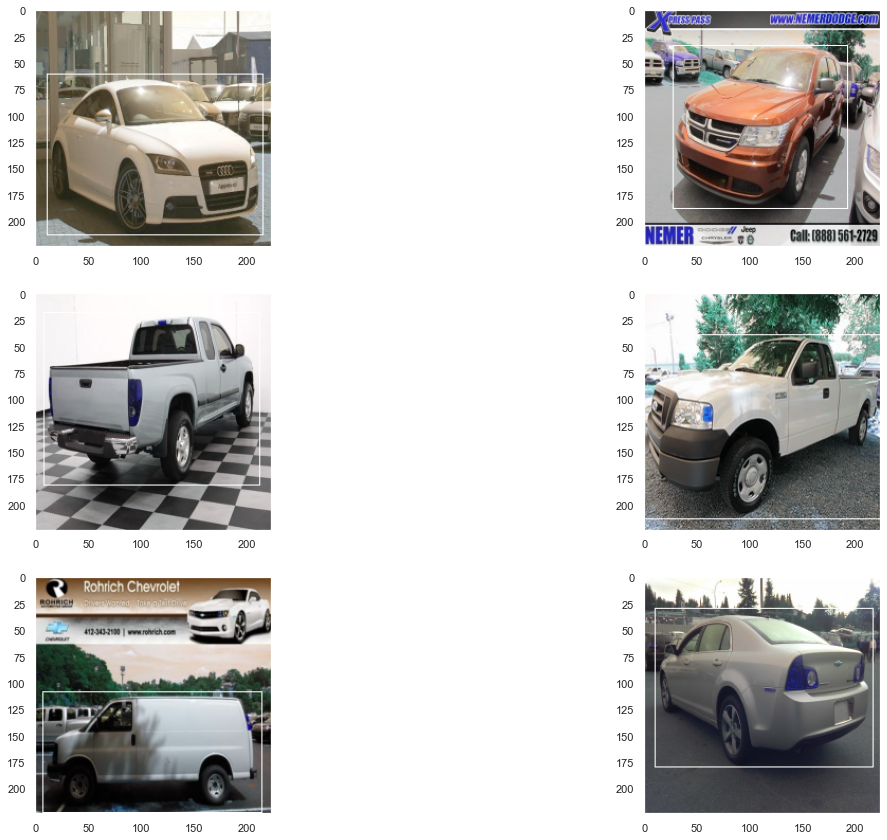

In [15]:
print ( 'Generating bounding boxes images for Eg Train Data')

i = 1
plt.figure(figsize=(20,20))
for no in [0 , 6, 67, 89 , 99, 340 ]:
    eg_car  = car_train_df.iloc[ no ]
    
    path = 'Car Images/Train Images/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
    img = cv2.imread( path )
    img_shape = img.shape
    img = cv2.resize(img, dsize = (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
    

    x1 = int(eg_car['X1']   * IMAGE_SIZE  / img_shape[1] -3 )           # Normalize bounding box by image size 
    y1 = int(eg_car['Y1']   * IMAGE_SIZE / img_shape[0] - 3 )        # Normalize bounding box by image size
    x2 = int(eg_car['X2']   * IMAGE_SIZE / img_shape[1] + 3)           # Normalize bounding box by image size
    y2 = int(eg_car['Y2']   * IMAGE_SIZE / img_shape[0] + 3 )          # Normalize bounding box by image size

    
    cv2.rectangle(img, (x1, y1), (x2, y2), (255,255,255) )

    i +=1
    plt.subplot(4,2,i+1)    
    plt.grid(False)
    plt.imshow(img);


### <font color='blue'>**5. Save training images with bounding box.**</font>





<b> While trying to read few images using cv2, I was getting return type as None. After troubleshooting, I found that this is due to folder name of images. Some of folder names have a '/' in it. Therefore, we will need to remove it. We have done it as part of pre-processing step.

In [ ]:
import os
file = os.chdir('/content/drive/MyDrive/Colab Notebooks/Capstone')  #change dir

<b> We will extract bounding boxes and then save those as image

In [ ]:
for i in range(len(car_train_df)):
  eg_car  = car_train_df.iloc[i]
  source_path = 'Car Images/Train Images/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
  dest_path = 'Car Images/Train Images Annoted/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )

  image = cv2.imread(source_path)
  if image is None:
    print(source_path)

  x1 = int(eg_car['X1'])          
  y1 = int(eg_car['Y1'])        
  x2 = int(eg_car['X2'])      
  y2 = int(eg_car['Y2'])    

  im2 = image[y1:y2,x1:x2]

  destdirname = 'Car Images/Train Images Annoted/{0}'.format( eg_car['CarLabel'])
  destfilename= eg_car['ImageName']

  if not os.path.exists(destdirname):
    os.mkdir(destdirname)

  cv2.imwrite(os.path.join(destdirname, destfilename), im2)


### Display few cropped training images

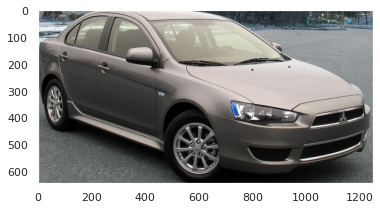

In [ ]:
eg_car  = car_train_df.iloc[8]
path = 'Car Images/Train Images Annoted/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
img = cv2.imread( path )
plt.grid(False)
plt.imshow(img)

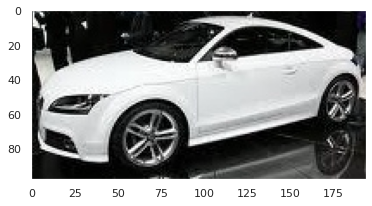

In [ ]:
eg_car  = car_train_df.iloc[16]
path = 'Car Images/Train Images Annoted/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
img = cv2.imread( path )
plt.grid(False)
plt.imshow(img)

### <font color='blue'>**6. Save test images with bounding box.**</font>

<b> We will extract bounding boxes and then save those as image

In [ ]:
for i in range(len(car_test_df)):
  eg_car  = car_test_df.iloc[i]
  source_path = 'Car Images/Test Images/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
  dest_path = 'Car Images/Test Images Annoted/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )

  image = cv2.imread(source_path)
  if image is None:
    print(source_path)

  x1 = int(eg_car['X1'])          
  y1 = int(eg_car['Y1'])        
  x2 = int(eg_car['X2'])      
  y2 = int(eg_car['Y2'])    

  im2 = image[y1:y2,x1:x2]

  destdirname = 'Car Images/Test Images Annoted/{0}'.format( eg_car['CarLabel'])
  destfilename= eg_car['ImageName']

  if not os.path.exists(destdirname):
    os.mkdir(destdirname)

  cv2.imwrite(os.path.join(destdirname, destfilename), im2)

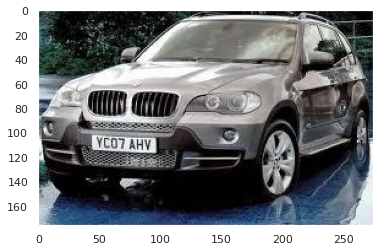

In [ ]:
eg_car  = car_test_df.iloc[8]
path = 'Car Images/Test Images Annoted/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
img = cv2.imread( path )
plt.grid(False)
plt.imshow(img)

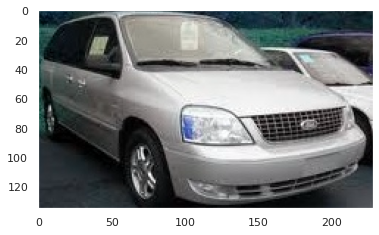

In [ ]:
eg_car  = car_test_df.iloc[11]
path = 'Car Images/Test Images Annoted/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
img = cv2.imread( path )
plt.grid(False)
plt.imshow(img)

In [ ]:
###Loading the data to train & test using Image Data Generator  
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Create data generator for training data with data augmentation and normalizing all
# values by 255

train_path = 'Car Images/Train Images Annoted'

test_path = 'Car Images/Test Images Annoted'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

generator = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,validation_split=0.3)


test_datagen = ImageDataGenerator(rescale = 1./255)

# Setting training data generator's source directory
# Setting the target size to resize all the images 

training_set = generator.flow_from_directory(train_path,
                                                 target_size = IMG_SIZE ,
                                                 batch_size = BATCH_SIZE,class_mode = 'categorical',
                                                subset='training')

# Setting testing data generator's source directory - validation data

test_set = generator.flow_from_directory(test_path,
                                            target_size = IMG_SIZE ,
                                                 batch_size = BATCH_SIZE,class_mode = 'categorical',
                                           subset='validation')



Found 5796 images belonging to 196 classes.
Found 2317 images belonging to 196 classes.


In [ ]:
### Checking if both test and train class names are matching

labels = (training_set.class_indices)

print(labels.items())

print()

labels_test = (test_set.class_indices)

print(labels_test.items())


print()

is_true= np.array_equal(np.unique(labels),np.unique(labels_test))


print("Is test & training class names matching :",is_true)




dict_items([('AM General Hummer SUV 2000', 0), ('Acura Integra Type R 2001', 1), ('Acura RL Sedan 2012', 2), ('Acura TL Sedan 2012', 3), ('Acura TL Type-S 2008', 4), ('Acura TSX Sedan 2012', 5), ('Acura ZDX Hatchback 2012', 6), ('Aston Martin V8 Vantage Convertible 2012', 7), ('Aston Martin V8 Vantage Coupe 2012', 8), ('Aston Martin Virage Convertible 2012', 9), ('Aston Martin Virage Coupe 2012', 10), ('Audi 100 Sedan 1994', 11), ('Audi 100 Wagon 1994', 12), ('Audi A5 Coupe 2012', 13), ('Audi R8 Coupe 2012', 14), ('Audi RS 4 Convertible 2008', 15), ('Audi S4 Sedan 2007', 16), ('Audi S4 Sedan 2012', 17), ('Audi S5 Convertible 2012', 18), ('Audi S5 Coupe 2012', 19), ('Audi S6 Sedan 2011', 20), ('Audi TT Hatchback 2011', 21), ('Audi TT RS Coupe 2012', 22), ('Audi TTS Coupe 2012', 23), ('Audi V8 Sedan 1994', 24), ('BMW 1 Series Convertible 2012', 25), ('BMW 1 Series Coupe 2012', 26), ('BMW 3 Series Sedan 2012', 27), ('BMW 3 Series Wagon 2012', 28), ('BMW 6 Series Convertible 2007', 29), ('


### <font color='blue'> 7.  Building CNN classifier</font>

In [ ]:
# Initialising the CNN classifier
classifier = Sequential()

INPUT_SIZE = (224, 224, 3)


# Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), input_shape = INPUT_SIZE, activation = 'relu', padding = 'same'))

# Add a Max Pooling layer of size 2X2
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the layer before fully connected layers
classifier.add(Flatten())

# Adding a fully connected layer with 512 neurons
classifier.add(Dense(units = 512, activation = 'relu'))

# Adding dropout with probability 0.5
classifier.add(Dropout(0.5))


# Adding a fully connected layer with 128 neurons
classifier.add(Dense(units = 128, activation = 'relu'))


# The final output layer with output size 196 classes for  the categorical classifcation
classifier.add(Dense(units = 196, activation = 'softmax'))

In [ ]:
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:

early = EarlyStopping(monitor='val_accuracy',min_delta=0,patience=40,verbose=1,mode='auto')

# There are 3823 training images and 500 test images in total
hist_CNNClassifier = classifier.fit(training_set,
                         steps_per_epoch = int(training_set.samples/BATCH_SIZE),
                         epochs = 20,
                         validation_data = test_set,
                         validation_steps = int(test_set.samples/BATCH_SIZE),
                         callbacks = [early])

Epoch 1/20
181/181 [==============================] - 2204s 12s/step - loss: 5.2822 - accuracy: 0.0047 - val_loss: 5.2769 - val_accuracy: 0.0074
Epoch 2/20
181/181 [==============================] - 452s 2s/step - loss: 5.2786 - accuracy: 0.0073 - val_loss: 5.2759 - val_accuracy: 0.0087
Epoch 3/20
181/181 [==============================] - 452s 2s/step - loss: 5.2721 - accuracy: 0.0083 - val_loss: 5.2569 - val_accuracy: 0.0091
Epoch 4/20
181/181 [==============================] - 451s 2s/step - loss: 5.2053 - accuracy: 0.0101 - val_loss: 5.1442 - val_accuracy: 0.0091
Epoch 5/20
181/181 [==============================] - 451s 2s/step - loss: 5.0732 - accuracy: 0.0186 - val_loss: 5.0251 - val_accuracy: 0.0174
Epoch 6/20
181/181 [==============================] - 451s 2s/step - loss: 4.9173 - accuracy: 0.0311 - val_loss: 4.8992 - val_accuracy: 0.0312
Epoch 7/20
181/181 [==============================] - 451s 2s/step - loss: 4.7218 - accuracy: 0.0461 - val_loss: 4.7973 - val_accuracy: 0.04

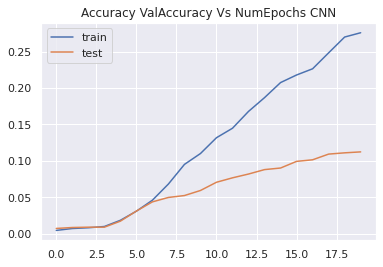

<function matplotlib.pyplot.show>

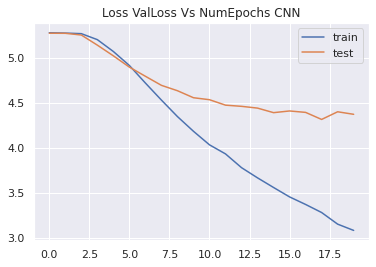

In [ ]:
train_loss = hist_CNNClassifier.history['loss']
val_loss   = hist_CNNClassifier.history['val_loss']

xc = hist_CNNClassifier.epoch
plt.title("Accuracy ValAccuracy Vs NumEpochs CNN")
plt.plot(xc,hist_CNNClassifier.history['accuracy'], label='train')
plt.plot(xc,hist_CNNClassifier.history['val_accuracy'], label='test')
plt.legend()
plt.show()

plt.figure()
plt.title("Loss ValLoss Vs NumEpochs CNN")
plt.plot(xc, train_loss,label='train')
plt.plot(xc, val_loss,label='test')
plt.legend()
plt.show

<font color='blue'>** pickle CNN classifier model and weights **</font>

In [ ]:
classifier.save('./classifier.h5')

classifier.save_weights('./classifier_weights.h5')

<font color='blue'>**8. Building Resnet50 model.**</font>



In [ ]:
from  tensorflow.keras.applications import resnet50
resnet50 = resnet50
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
#for layer in conv_model.layers: 
 #   layer.trainable = False

x = Flatten()(conv_model.layers[-1].output)

#x = Flatten()(conv_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(224, activation='relu')(x)
x = Dense(224, activation='relu')(x)

predictions = Dense(196, activation='softmax')(x)

full_model = Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
## compiling resnet50 model 
opt= Adam(learning_rate=0.01)
full_model.compile(optimizer= opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
early = EarlyStopping(monitor='val_accuracy',min_delta=0,patience=40,verbose=1,mode='auto')
   

In [ ]:
full_model.fit(training_set,steps_per_epoch = 2, epochs =30, validation_data = test_set,
		        validation_steps = 1,callbacks = [early])

Epoch 1/30
2/2 [==============================] - 67s 33s/step - loss: 169.4210 - accuracy: 0.0000e+00 - val_loss: 1736714183770112.0000 - val_accuracy: 0.0000e+00
Epoch 2/30
2/2 [==============================] - 58s 31s/step - loss: 125.3960 - accuracy: 0.0000e+00 - val_loss: 30414204663400235008.0000 - val_accuracy: 0.0000e+00
Epoch 3/30
2/2 [==============================] - 56s 30s/step - loss: 6.5134 - accuracy: 0.0156 - val_loss: 16305093299710531207168.0000 - val_accuracy: 0.0000e+00
Epoch 4/30
2/2 [==============================] - 57s 31s/step - loss: 5.4050 - accuracy: 0.0000e+00 - val_loss: 56311528056363277090816.0000 - val_accuracy: 0.0000e+00
Epoch 5/30
2/2 [==============================] - 56s 31s/step - loss: 5.2940 - accuracy: 0.0000e+00 - val_loss: 24887598605990858063872.0000 - val_accuracy: 0.0312
Epoch 6/30
2/2 [==============================] - 57s 31s/step - loss: 5.6139 - accuracy: 0.0156 - val_loss: 5628538015692676399104.0000 - val_accuracy: 0.0000e+00
Epoch